In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
from os import getcwd as cwd
import pandas as pd
import random
import sys
import torch
import torch.nn as nn
import torch.utils.data as data
from tqdm import tqdm
import visdom
from PIL import Image

# Logger
from IO.logger import Logger
# Loader
from dataset.classification.loader import create_validation_split, load_validation_data
# Data Sampling
from dataset.classification.sampler import adopt_sampling
# Dataset
from dataset.classification.dataset import insects_dataset
# Model
from model.resnet.resnet import ResNet
from model.resnet.utils import define_weight
from model.resnet.predict import test_classification
from model.optimizer import AdamW
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Statistics
from evaluation.classification.statistics import compute_each_size_df, compute_all_size_df
# Visualize
from evaluation.classification.visualize import create_confusion_matrix, plot_df_distrib_size

# Train Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_20200806_oversample"
    # data split
    train_ratio = 0.8 # unused parameter
    test_ratio = 0.2
    # paths
    all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std_20200806")
    model_root = pj(cwd(), "output_model/classification/ResNet101", experiment_name)
    figure_root = pj(cwd(), "figure/classification/ResNet101", experiment_name)
    # train config
    model_name = "resnet50" # choice ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
    bs = 20
    lr = 1e-5
    lamda = 0
    nepoch = 100
    pretrain = True
    param_freeze = False
    sampling = "OverSample" # choice [None, "RandomSample", "OverSample"]
    method_aug = ["HorizontalFlip", "VerticalFlip", "Rotate", "Contrast", "Sharpen", "Invert"]
    optimizer = "AdamW" # choice ["Adam, AdamW"]
    activation_function = "ReLU" # choice ["ReLU", "LeakyReLU", "RReLU"]
    decoder = None # choice [None, "Concatenate", "FPN"]
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

In [4]:
dataset_name = args.all_data_path.split('/')[-1]
if dataset_name == 'classify_insect_std':
    args.labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_std_resizeFAR':
    args.labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_std_resize':
    args.labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_std_plus_other':
    args.labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera', 'Other']
elif dataset_name == 'classify_insect_std_20200806':
    args.labels = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera']

# Train

In [5]:
def train(model, counts, train_dataloader, valid_dataloader, test_dataloader, lr=1e-5, nepoch=40, visdom=False):
    # define weight and create loss function
    ce = torch.nn.CrossEntropyLoss(define_weight(counts)).cuda()
    l2_loss = nn.MSELoss(reduction='elementwise_mean').cuda()
    
    # define optimizer
    if args.optimizer == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif args.optimizer == "AdamW":
        opt = AdamW(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    epoch_tqdm = tqdm(range(nepoch),leave=False)
    # training
    for epoch in epoch_tqdm:
        sum_cls_loss = 0
        sum_norm_loss = 0
        total_loss = 0
        epoch_tqdm.set_description("epoch=%s" % (epoch))
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.cuda()
            opt.zero_grad()
            out = model(x)
            cls_loss = ce(out, y)
            if args.lamda != 0:
                norm_loss = 0
                for param in model.parameters():
                    param_target = torch.zeros(param.size()).cuda()
                    norm_loss += l2_loss(param, param_target)

                norm_loss = norm_loss * args.lamda
                sum_cls_loss += cls_loss.item()
                sum_norm_loss += norm_loss.item()
                loss = cls_loss + norm_loss
            else:
                norm_loss = 0
                sum_cls_loss += cls_loss.item()
                sum_norm_loss = 0
                loss = cls_loss
            
            total_loss += loss.item()
            loss.backward()
            opt.step()
            if args.lamda != 0:
                sys.stdout.write("\rcls_loss=%f, norm_loss=%f" % (cls_loss.item(), norm_loss.item()))
            else:
                sys.stdout.write("\rcls_loss=%f" % (cls_loss.item()))
            sys.stdout.flush()
        
        model.training = False
        valid_acc = accuracy(model, valid_dataloader)
        te_acc = accuracy(model, test_dataloader)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, sum_cls_loss, win_cls_loss)
            visualize(vis, epoch+1, sum_norm_loss, win_norm_loss)
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
            visualize(vis, epoch+1, valid_acc, win_train_acc)
        print("sum_cls_loss=%f, sum_norm_loss=%f, total_loss=%f, train_acc=%f, te_acc=%f" % (sum_cls_loss, sum_norm_loss, total_loss, valid_acc, te_acc))

# Set Visdom

In [6]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.port)
    
    win_cls_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='cls_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_norm_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='norm_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_train_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_train_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )

Setting up a new session...


In [7]:
def visualize(vis, phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

### Save args

In [8]:
args_logger = Logger(args)
args_logger.save()

# Cross Validation

In [9]:
model_save_path = pj(args.model_root, "final.pth")
if os.path.exists(args.model_root) is False:
    os.makedirs(args.model_root)
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)
result = []
for valid_count in range(valid_num):
    # create validation data
    valid_train_idx = adopt_sampling(Y, train_idxs[valid_count], args.sampling)
    valid_test_idx = test_idxs[valid_count]
    xtr, ytr, xte, yte = load_validation_data(X, Y, valid_train_idx, valid_test_idx)
    _, counts = np.unique(ytr, return_counts=True)
    # create dataloader
    train_dataset = insects_dataset(xtr, ytr, training=True, method_aug=args.method_aug)
    train_dataloader = data.DataLoader(train_dataset, args.bs, num_workers=args.bs, shuffle=True)
    valid_dataset = insects_dataset(xtr, ytr, training=False)
    valid_dataloader = data.DataLoader(valid_dataset, args.bs, num_workers=args.bs, shuffle=False)
    test_dataset = insects_dataset(xte, yte, training=False)
    test_dataloader = data.DataLoader(test_dataset, args.bs, num_workers=args.bs, shuffle=False)
    
    # create model
    model = ResNet(args.model_name, len(args.labels), pretrain=args.pretrain, training=True, param_freeze=args.param_freeze, activation_function=args.activation_function, decoder=args.decoder).cuda()
    
    # training
    train(model, counts, train_dataloader, valid_dataloader, test_dataloader, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom)
    torch.save(model.state_dict(), model_save_path)
    
    model.training = False
    matrix = confusion_matrix(model, test_dataloader, args.labels)
    model.training = True
    df = pd.DataFrame(matrix)
    display(df)
    if valid_count == 0:
        validation_matrix = matrix
        x_all = xte
        y_all = yte
    else:
        validation_matrix += matrix
        x_all = np.concatenate([x_all, xte])
        y_all = np.concatenate([y_all, yte])
    
    result.extend(test_classification(model, test_dataloader))

sampling == OverSample
augment == method_aug
---
HorizontalFlip
VerticalFlip
Rotate
Contrast
Sharpen
Invert
---
augment == None
augment == None
activation_function = ReLU


epoch=0:   0%|          | 0/100 [00:00<?, ?it/s]

cls_loss=1.228162

epoch=1:   1%|          | 1/100 [00:43<1:12:11, 43.75s/it]

sum_cls_loss=349.137199, sum_norm_loss=0.000000, total_loss=349.137199, train_acc=0.832132, te_acc=0.789216
cls_loss=0.355287

epoch=2:   2%|▏         | 2/100 [01:27<1:11:31, 43.79s/it]

sum_cls_loss=188.651388, sum_norm_loss=0.000000, total_loss=188.651388, train_acc=0.928424, te_acc=0.848039
cls_loss=0.496967

epoch=3:   3%|▎         | 3/100 [02:12<1:11:24, 44.17s/it]

sum_cls_loss=130.266611, sum_norm_loss=0.000000, total_loss=130.266611, train_acc=0.966014, te_acc=0.877451
cls_loss=0.954032

epoch=4:   4%|▍         | 4/100 [02:58<1:11:15, 44.54s/it]

sum_cls_loss=109.762197, sum_norm_loss=0.000000, total_loss=109.762197, train_acc=0.981119, te_acc=0.874183
cls_loss=0.292421

epoch=5:   5%|▌         | 5/100 [03:43<1:10:55, 44.80s/it]

sum_cls_loss=86.532401, sum_norm_loss=0.000000, total_loss=86.532401, train_acc=0.988500, te_acc=0.883987
cls_loss=0.726857

epoch=6:   6%|▌         | 6/100 [04:29<1:10:33, 45.04s/it]

sum_cls_loss=79.100811, sum_norm_loss=0.000000, total_loss=79.100811, train_acc=0.992791, te_acc=0.887255
cls_loss=0.245645

epoch=7:   7%|▋         | 7/100 [05:14<1:10:00, 45.17s/it]

sum_cls_loss=63.020011, sum_norm_loss=0.000000, total_loss=63.020011, train_acc=0.992276, te_acc=0.895425
cls_loss=0.036600

epoch=8:   8%|▊         | 8/100 [05:59<1:09:17, 45.20s/it]

sum_cls_loss=58.299842, sum_norm_loss=0.000000, total_loss=58.299842, train_acc=0.992963, te_acc=0.892157
cls_loss=0.377008

epoch=9:   9%|▉         | 9/100 [06:44<1:08:30, 45.17s/it]

sum_cls_loss=57.546430, sum_norm_loss=0.000000, total_loss=57.546430, train_acc=0.997254, te_acc=0.888889
cls_loss=0.099621

epoch=10:  10%|█         | 10/100 [07:30<1:07:51, 45.24s/it]

sum_cls_loss=48.919521, sum_norm_loss=0.000000, total_loss=48.919521, train_acc=0.997769, te_acc=0.897059
cls_loss=0.292861

epoch=11:  11%|█         | 11/100 [08:15<1:07:06, 45.24s/it]

sum_cls_loss=45.339423, sum_norm_loss=0.000000, total_loss=45.339423, train_acc=0.998970, te_acc=0.905229
cls_loss=0.167427

epoch=12:  12%|█▏        | 12/100 [09:00<1:06:19, 45.22s/it]

sum_cls_loss=40.876810, sum_norm_loss=0.000000, total_loss=40.876810, train_acc=0.999485, te_acc=0.895425
cls_loss=0.050993

epoch=13:  13%|█▎        | 13/100 [09:45<1:05:27, 45.15s/it]

sum_cls_loss=41.733440, sum_norm_loss=0.000000, total_loss=41.733440, train_acc=0.999142, te_acc=0.905229
cls_loss=0.228052

epoch=14:  14%|█▍        | 14/100 [10:31<1:04:48, 45.21s/it]

sum_cls_loss=36.824559, sum_norm_loss=0.000000, total_loss=36.824559, train_acc=0.999142, te_acc=0.900327
cls_loss=0.026334

epoch=15:  15%|█▌        | 15/100 [11:16<1:04:06, 45.26s/it]

sum_cls_loss=36.665364, sum_norm_loss=0.000000, total_loss=36.665364, train_acc=0.999657, te_acc=0.900327
cls_loss=0.062360

epoch=16:  16%|█▌        | 16/100 [12:01<1:03:21, 45.25s/it]

sum_cls_loss=33.575738, sum_norm_loss=0.000000, total_loss=33.575738, train_acc=0.999657, te_acc=0.890523
cls_loss=0.030447

epoch=17:  17%|█▋        | 17/100 [12:46<1:02:35, 45.25s/it]

sum_cls_loss=29.994210, sum_norm_loss=0.000000, total_loss=29.994210, train_acc=1.000000, te_acc=0.897059
cls_loss=0.010798

epoch=18:  18%|█▊        | 18/100 [13:32<1:01:53, 45.28s/it]

sum_cls_loss=29.729539, sum_norm_loss=0.000000, total_loss=29.729539, train_acc=0.999142, te_acc=0.900327
cls_loss=0.011795

epoch=19:  19%|█▉        | 19/100 [14:17<1:01:07, 45.28s/it]

sum_cls_loss=25.201272, sum_norm_loss=0.000000, total_loss=25.201272, train_acc=1.000000, te_acc=0.898693
cls_loss=0.025080

epoch=20:  20%|██        | 20/100 [15:03<1:00:33, 45.41s/it]

sum_cls_loss=28.674015, sum_norm_loss=0.000000, total_loss=28.674015, train_acc=0.998798, te_acc=0.901961
cls_loss=0.011030

epoch=21:  21%|██        | 21/100 [15:48<59:40, 45.32s/it]  

sum_cls_loss=27.786469, sum_norm_loss=0.000000, total_loss=27.786469, train_acc=0.999828, te_acc=0.900327
cls_loss=0.211918

epoch=22:  22%|██▏       | 22/100 [16:33<58:57, 45.35s/it]

sum_cls_loss=25.800016, sum_norm_loss=0.000000, total_loss=25.800016, train_acc=0.999828, te_acc=0.900327
cls_loss=0.667831

epoch=23:  23%|██▎       | 23/100 [17:18<58:07, 45.29s/it]

sum_cls_loss=28.541674, sum_norm_loss=0.000000, total_loss=28.541674, train_acc=0.999657, te_acc=0.893791
cls_loss=0.014656

epoch=24:  24%|██▍       | 24/100 [18:04<57:21, 45.29s/it]

sum_cls_loss=25.068197, sum_norm_loss=0.000000, total_loss=25.068197, train_acc=1.000000, te_acc=0.897059
cls_loss=0.001535

epoch=25:  25%|██▌       | 25/100 [18:49<56:31, 45.21s/it]

sum_cls_loss=23.831524, sum_norm_loss=0.000000, total_loss=23.831524, train_acc=1.000000, te_acc=0.892157
cls_loss=0.027169

epoch=26:  26%|██▌       | 26/100 [19:34<55:51, 45.28s/it]

sum_cls_loss=23.843275, sum_norm_loss=0.000000, total_loss=23.843275, train_acc=1.000000, te_acc=0.903595
cls_loss=0.042718

epoch=27:  27%|██▋       | 27/100 [20:19<54:58, 45.18s/it]

sum_cls_loss=21.808917, sum_norm_loss=0.000000, total_loss=21.808917, train_acc=1.000000, te_acc=0.903595
cls_loss=0.058691

epoch=28:  28%|██▊       | 28/100 [21:04<54:07, 45.11s/it]

sum_cls_loss=19.837269, sum_norm_loss=0.000000, total_loss=19.837269, train_acc=0.999828, te_acc=0.898693
cls_loss=0.005371

epoch=29:  29%|██▉       | 29/100 [21:49<53:27, 45.17s/it]

sum_cls_loss=16.602593, sum_norm_loss=0.000000, total_loss=16.602593, train_acc=1.000000, te_acc=0.903595
cls_loss=0.041494

epoch=30:  30%|███       | 30/100 [22:35<52:41, 45.17s/it]

sum_cls_loss=20.163059, sum_norm_loss=0.000000, total_loss=20.163059, train_acc=1.000000, te_acc=0.897059
cls_loss=0.008225

epoch=31:  31%|███       | 31/100 [23:20<51:59, 45.21s/it]

sum_cls_loss=17.162452, sum_norm_loss=0.000000, total_loss=17.162452, train_acc=1.000000, te_acc=0.900327
cls_loss=0.010758

epoch=32:  32%|███▏      | 32/100 [24:05<51:13, 45.20s/it]

sum_cls_loss=19.189775, sum_norm_loss=0.000000, total_loss=19.189775, train_acc=0.999485, te_acc=0.911765
cls_loss=0.331614

epoch=33:  33%|███▎      | 33/100 [24:50<50:30, 45.23s/it]

sum_cls_loss=16.314544, sum_norm_loss=0.000000, total_loss=16.314544, train_acc=1.000000, te_acc=0.908497
cls_loss=0.367606

epoch=34:  34%|███▍      | 34/100 [25:36<49:45, 45.23s/it]

sum_cls_loss=16.204641, sum_norm_loss=0.000000, total_loss=16.204641, train_acc=1.000000, te_acc=0.911765
cls_loss=0.056406

epoch=35:  35%|███▌      | 35/100 [26:21<49:03, 45.29s/it]

sum_cls_loss=18.026408, sum_norm_loss=0.000000, total_loss=18.026408, train_acc=1.000000, te_acc=0.911765
cls_loss=0.082545

epoch=36:  36%|███▌      | 36/100 [27:06<48:19, 45.31s/it]

sum_cls_loss=16.541943, sum_norm_loss=0.000000, total_loss=16.541943, train_acc=1.000000, te_acc=0.913399
cls_loss=0.037330

epoch=37:  37%|███▋      | 37/100 [27:52<47:36, 45.34s/it]

sum_cls_loss=16.284276, sum_norm_loss=0.000000, total_loss=16.284276, train_acc=1.000000, te_acc=0.913399
cls_loss=0.530943

epoch=38:  38%|███▊      | 38/100 [28:37<46:45, 45.26s/it]

sum_cls_loss=14.487200, sum_norm_loss=0.000000, total_loss=14.487200, train_acc=1.000000, te_acc=0.901961
cls_loss=0.017212

epoch=39:  39%|███▉      | 39/100 [29:22<46:06, 45.35s/it]

sum_cls_loss=18.127446, sum_norm_loss=0.000000, total_loss=18.127446, train_acc=1.000000, te_acc=0.906863
cls_loss=0.003000

epoch=40:  40%|████      | 40/100 [30:08<45:16, 45.28s/it]

sum_cls_loss=13.964787, sum_norm_loss=0.000000, total_loss=13.964787, train_acc=1.000000, te_acc=0.903595
cls_loss=0.047541

epoch=41:  41%|████      | 41/100 [30:53<44:37, 45.37s/it]

sum_cls_loss=15.921682, sum_norm_loss=0.000000, total_loss=15.921682, train_acc=1.000000, te_acc=0.911765
cls_loss=0.001739

epoch=42:  42%|████▏     | 42/100 [31:39<43:52, 45.39s/it]

sum_cls_loss=14.838540, sum_norm_loss=0.000000, total_loss=14.838540, train_acc=1.000000, te_acc=0.918301
cls_loss=0.009853

epoch=43:  43%|████▎     | 43/100 [32:23<42:58, 45.24s/it]

sum_cls_loss=11.473354, sum_norm_loss=0.000000, total_loss=11.473354, train_acc=1.000000, te_acc=0.908497
cls_loss=0.044577

epoch=44:  44%|████▍     | 44/100 [33:09<42:11, 45.21s/it]

sum_cls_loss=13.166907, sum_norm_loss=0.000000, total_loss=13.166907, train_acc=1.000000, te_acc=0.900327
cls_loss=0.120362

epoch=45:  45%|████▌     | 45/100 [33:54<41:22, 45.13s/it]

sum_cls_loss=14.038169, sum_norm_loss=0.000000, total_loss=14.038169, train_acc=1.000000, te_acc=0.915033
cls_loss=0.230895

epoch=46:  46%|████▌     | 46/100 [34:39<40:37, 45.14s/it]

sum_cls_loss=13.083390, sum_norm_loss=0.000000, total_loss=13.083390, train_acc=1.000000, te_acc=0.901961
cls_loss=0.221143

epoch=47:  47%|████▋     | 47/100 [35:24<39:52, 45.14s/it]

sum_cls_loss=13.239060, sum_norm_loss=0.000000, total_loss=13.239060, train_acc=1.000000, te_acc=0.906863
cls_loss=0.023384

epoch=48:  48%|████▊     | 48/100 [36:09<39:07, 45.14s/it]

sum_cls_loss=12.834804, sum_norm_loss=0.000000, total_loss=12.834804, train_acc=0.999657, te_acc=0.915033
cls_loss=0.485405

epoch=49:  49%|████▉     | 49/100 [36:54<38:26, 45.23s/it]

sum_cls_loss=12.627329, sum_norm_loss=0.000000, total_loss=12.627329, train_acc=1.000000, te_acc=0.901961
cls_loss=0.037468

epoch=50:  50%|█████     | 50/100 [37:40<37:43, 45.27s/it]

sum_cls_loss=11.236959, sum_norm_loss=0.000000, total_loss=11.236959, train_acc=1.000000, te_acc=0.910131
cls_loss=0.007702

epoch=51:  51%|█████     | 51/100 [38:25<36:56, 45.24s/it]

sum_cls_loss=11.202090, sum_norm_loss=0.000000, total_loss=11.202090, train_acc=1.000000, te_acc=0.900327
cls_loss=0.830106

epoch=52:  52%|█████▏    | 52/100 [39:10<36:11, 45.23s/it]

sum_cls_loss=10.303252, sum_norm_loss=0.000000, total_loss=10.303252, train_acc=1.000000, te_acc=0.915033
cls_loss=0.093174

epoch=53:  53%|█████▎    | 53/100 [39:55<35:26, 45.25s/it]

sum_cls_loss=11.887728, sum_norm_loss=0.000000, total_loss=11.887728, train_acc=1.000000, te_acc=0.903595
cls_loss=0.002072

epoch=54:  54%|█████▍    | 54/100 [40:41<34:42, 45.27s/it]

sum_cls_loss=12.410072, sum_norm_loss=0.000000, total_loss=12.410072, train_acc=0.999657, te_acc=0.915033
cls_loss=0.002634

epoch=55:  55%|█████▌    | 55/100 [41:26<33:58, 45.30s/it]

sum_cls_loss=10.411258, sum_norm_loss=0.000000, total_loss=10.411258, train_acc=1.000000, te_acc=0.906863
cls_loss=0.000553

epoch=56:  56%|█████▌    | 56/100 [42:12<33:15, 45.36s/it]

sum_cls_loss=9.961780, sum_norm_loss=0.000000, total_loss=9.961780, train_acc=1.000000, te_acc=0.898693
cls_loss=0.000821

epoch=57:  57%|█████▋    | 57/100 [42:57<32:30, 45.35s/it]

sum_cls_loss=9.782030, sum_norm_loss=0.000000, total_loss=9.782030, train_acc=1.000000, te_acc=0.913399
cls_loss=0.056973

epoch=58:  58%|█████▊    | 58/100 [43:42<31:44, 45.35s/it]

sum_cls_loss=8.052346, sum_norm_loss=0.000000, total_loss=8.052346, train_acc=1.000000, te_acc=0.905229
cls_loss=0.004652

epoch=59:  59%|█████▉    | 59/100 [44:28<30:57, 45.31s/it]

sum_cls_loss=12.484126, sum_norm_loss=0.000000, total_loss=12.484126, train_acc=1.000000, te_acc=0.918301
cls_loss=0.003980

epoch=60:  60%|██████    | 60/100 [45:12<30:07, 45.19s/it]

sum_cls_loss=9.799274, sum_norm_loss=0.000000, total_loss=9.799274, train_acc=1.000000, te_acc=0.913399
cls_loss=0.024954

epoch=61:  61%|██████    | 61/100 [45:58<29:23, 45.22s/it]

sum_cls_loss=11.672506, sum_norm_loss=0.000000, total_loss=11.672506, train_acc=1.000000, te_acc=0.919935
cls_loss=0.008587

epoch=62:  62%|██████▏   | 62/100 [46:43<28:37, 45.19s/it]

sum_cls_loss=9.299469, sum_norm_loss=0.000000, total_loss=9.299469, train_acc=1.000000, te_acc=0.910131
cls_loss=0.001856

epoch=63:  63%|██████▎   | 63/100 [47:28<27:51, 45.18s/it]

sum_cls_loss=8.433432, sum_norm_loss=0.000000, total_loss=8.433432, train_acc=0.999828, te_acc=0.906863
cls_loss=0.008476

epoch=64:  64%|██████▍   | 64/100 [48:13<27:08, 45.24s/it]

sum_cls_loss=10.170132, sum_norm_loss=0.000000, total_loss=10.170132, train_acc=0.999828, te_acc=0.900327
cls_loss=0.015417

epoch=65:  65%|██████▌   | 65/100 [48:59<26:23, 45.25s/it]

sum_cls_loss=8.483978, sum_norm_loss=0.000000, total_loss=8.483978, train_acc=1.000000, te_acc=0.910131
cls_loss=0.000347

epoch=66:  66%|██████▌   | 66/100 [49:44<25:38, 45.26s/it]

sum_cls_loss=7.565371, sum_norm_loss=0.000000, total_loss=7.565371, train_acc=1.000000, te_acc=0.908497
cls_loss=0.000688

epoch=67:  67%|██████▋   | 67/100 [50:29<24:55, 45.32s/it]

sum_cls_loss=8.064326, sum_norm_loss=0.000000, total_loss=8.064326, train_acc=1.000000, te_acc=0.898693
cls_loss=0.000521

epoch=68:  68%|██████▊   | 68/100 [51:15<24:10, 45.31s/it]

sum_cls_loss=8.825007, sum_norm_loss=0.000000, total_loss=8.825007, train_acc=1.000000, te_acc=0.900327
cls_loss=0.000657

epoch=69:  69%|██████▉   | 69/100 [52:00<23:24, 45.31s/it]

sum_cls_loss=7.771076, sum_norm_loss=0.000000, total_loss=7.771076, train_acc=1.000000, te_acc=0.901961
cls_loss=0.008380

epoch=70:  70%|███████   | 70/100 [52:45<22:38, 45.30s/it]

sum_cls_loss=7.471357, sum_norm_loss=0.000000, total_loss=7.471357, train_acc=1.000000, te_acc=0.897059
cls_loss=0.018919

epoch=71:  71%|███████   | 71/100 [53:31<21:53, 45.28s/it]

sum_cls_loss=7.456403, sum_norm_loss=0.000000, total_loss=7.456403, train_acc=1.000000, te_acc=0.900327
cls_loss=2.646664

epoch=72:  72%|███████▏  | 72/100 [54:16<21:09, 45.34s/it]

sum_cls_loss=9.566469, sum_norm_loss=0.000000, total_loss=9.566469, train_acc=1.000000, te_acc=0.897059
cls_loss=0.003259

epoch=73:  73%|███████▎  | 73/100 [55:01<20:23, 45.32s/it]

sum_cls_loss=8.983189, sum_norm_loss=0.000000, total_loss=8.983189, train_acc=1.000000, te_acc=0.895425
cls_loss=0.014800

epoch=74:  74%|███████▍  | 74/100 [55:47<19:37, 45.30s/it]

sum_cls_loss=7.749301, sum_norm_loss=0.000000, total_loss=7.749301, train_acc=1.000000, te_acc=0.898693
cls_loss=0.004230

epoch=75:  75%|███████▌  | 75/100 [56:32<18:52, 45.29s/it]

sum_cls_loss=7.224413, sum_norm_loss=0.000000, total_loss=7.224413, train_acc=1.000000, te_acc=0.900327
cls_loss=0.001468

epoch=76:  76%|███████▌  | 76/100 [57:17<18:07, 45.30s/it]

sum_cls_loss=7.551358, sum_norm_loss=0.000000, total_loss=7.551358, train_acc=1.000000, te_acc=0.893791
cls_loss=0.007930

epoch=77:  77%|███████▋  | 77/100 [58:02<17:20, 45.25s/it]

sum_cls_loss=7.460392, sum_norm_loss=0.000000, total_loss=7.460392, train_acc=1.000000, te_acc=0.895425
cls_loss=0.204255

epoch=78:  78%|███████▊  | 78/100 [58:48<16:36, 45.28s/it]

sum_cls_loss=6.344983, sum_norm_loss=0.000000, total_loss=6.344983, train_acc=1.000000, te_acc=0.885621
cls_loss=0.000621

epoch=79:  79%|███████▉  | 79/100 [59:33<15:51, 45.33s/it]

sum_cls_loss=6.022111, sum_norm_loss=0.000000, total_loss=6.022111, train_acc=1.000000, te_acc=0.898693
cls_loss=0.007189

epoch=80:  80%|████████  | 80/100 [1:00:18<15:05, 45.25s/it]

sum_cls_loss=6.657978, sum_norm_loss=0.000000, total_loss=6.657978, train_acc=1.000000, te_acc=0.897059
cls_loss=0.001084

epoch=81:  81%|████████  | 81/100 [1:01:03<14:19, 45.23s/it]

sum_cls_loss=8.581438, sum_norm_loss=0.000000, total_loss=8.581438, train_acc=1.000000, te_acc=0.898693
cls_loss=0.001905

epoch=82:  82%|████████▏ | 82/100 [1:01:48<13:33, 45.22s/it]

sum_cls_loss=9.448008, sum_norm_loss=0.000000, total_loss=9.448008, train_acc=1.000000, te_acc=0.893791
cls_loss=0.002148

epoch=83:  83%|████████▎ | 83/100 [1:02:34<12:47, 45.17s/it]

sum_cls_loss=7.363735, sum_norm_loss=0.000000, total_loss=7.363735, train_acc=1.000000, te_acc=0.895425
cls_loss=0.001986

epoch=84:  84%|████████▍ | 84/100 [1:03:19<12:06, 45.38s/it]

sum_cls_loss=7.204680, sum_norm_loss=0.000000, total_loss=7.204680, train_acc=1.000000, te_acc=0.898693
cls_loss=0.168622

epoch=85:  85%|████████▌ | 85/100 [1:04:05<11:20, 45.36s/it]

sum_cls_loss=5.555548, sum_norm_loss=0.000000, total_loss=5.555548, train_acc=1.000000, te_acc=0.888889
cls_loss=0.013118

epoch=86:  86%|████████▌ | 86/100 [1:04:50<10:35, 45.41s/it]

sum_cls_loss=8.110661, sum_norm_loss=0.000000, total_loss=8.110661, train_acc=1.000000, te_acc=0.893791
cls_loss=0.005058

epoch=87:  87%|████████▋ | 87/100 [1:05:36<09:50, 45.41s/it]

sum_cls_loss=5.339495, sum_norm_loss=0.000000, total_loss=5.339495, train_acc=1.000000, te_acc=0.906863
cls_loss=0.002078

epoch=88:  88%|████████▊ | 88/100 [1:06:21<09:05, 45.43s/it]

sum_cls_loss=6.235974, sum_norm_loss=0.000000, total_loss=6.235974, train_acc=1.000000, te_acc=0.906863
cls_loss=0.000453

epoch=89:  89%|████████▉ | 89/100 [1:07:07<08:19, 45.43s/it]

sum_cls_loss=7.727449, sum_norm_loss=0.000000, total_loss=7.727449, train_acc=1.000000, te_acc=0.900327
cls_loss=0.044260

epoch=90:  90%|█████████ | 90/100 [1:07:52<07:33, 45.38s/it]

sum_cls_loss=6.895471, sum_norm_loss=0.000000, total_loss=6.895471, train_acc=1.000000, te_acc=0.888889
cls_loss=0.001116

epoch=91:  91%|█████████ | 91/100 [1:08:37<06:49, 45.45s/it]

sum_cls_loss=7.903089, sum_norm_loss=0.000000, total_loss=7.903089, train_acc=1.000000, te_acc=0.898693
cls_loss=0.001186

epoch=92:  92%|█████████▏| 92/100 [1:09:23<06:03, 45.44s/it]

sum_cls_loss=5.519968, sum_norm_loss=0.000000, total_loss=5.519968, train_acc=1.000000, te_acc=0.905229
cls_loss=0.002165

epoch=93:  93%|█████████▎| 93/100 [1:10:08<05:18, 45.50s/it]

sum_cls_loss=5.840298, sum_norm_loss=0.000000, total_loss=5.840298, train_acc=1.000000, te_acc=0.908497
cls_loss=0.014803

epoch=94:  94%|█████████▍| 94/100 [1:10:54<04:33, 45.53s/it]

sum_cls_loss=5.635008, sum_norm_loss=0.000000, total_loss=5.635008, train_acc=1.000000, te_acc=0.895425
cls_loss=0.001266

epoch=95:  95%|█████████▌| 95/100 [1:11:40<03:47, 45.52s/it]

sum_cls_loss=5.484334, sum_norm_loss=0.000000, total_loss=5.484334, train_acc=1.000000, te_acc=0.900327
cls_loss=0.015668

epoch=96:  96%|█████████▌| 96/100 [1:12:25<03:01, 45.46s/it]

sum_cls_loss=5.963428, sum_norm_loss=0.000000, total_loss=5.963428, train_acc=1.000000, te_acc=0.913399
cls_loss=0.000641

epoch=97:  97%|█████████▋| 97/100 [1:13:10<02:16, 45.38s/it]

sum_cls_loss=5.149986, sum_norm_loss=0.000000, total_loss=5.149986, train_acc=1.000000, te_acc=0.915033
cls_loss=0.001350

epoch=98:  98%|█████████▊| 98/100 [1:13:56<01:30, 45.40s/it]

sum_cls_loss=5.592726, sum_norm_loss=0.000000, total_loss=5.592726, train_acc=1.000000, te_acc=0.910131
cls_loss=0.000402

epoch=99:  99%|█████████▉| 99/100 [1:14:41<00:45, 45.38s/it]

sum_cls_loss=5.984001, sum_norm_loss=0.000000, total_loss=5.984001, train_acc=1.000000, te_acc=0.908497
cls_loss=0.004844

sum_cls_loss=5.736140, sum_norm_loss=0.000000, total_loss=5.736140, train_acc=1.000000, te_acc=0.893791


,0,1,2,3,4,5
0,91.0,0.0,4.0,4.0,1.0,1.0
1,0.0,25.0,3.0,1.0,0.0,0.0
2,7.0,1.0,42.0,1.0,6.0,2.0
3,1.0,0.0,1.0,232.0,3.0,6.0
4,3.0,0.0,5.0,0.0,86.0,5.0
5,2.0,0.0,2.0,1.0,5.0,71.0


sampling == OverSample
augment == method_aug
---
HorizontalFlip
VerticalFlip
Rotate
Contrast
Sharpen
Invert
---
augment == None
augment == None
activation_function = ReLU


epoch=0:   0%|          | 0/100 [00:00<?, ?it/s]

cls_loss=0.474358

epoch=1:   1%|          | 1/100 [00:45<1:14:27, 45.13s/it]

sum_cls_loss=352.389776, sum_norm_loss=0.000000, total_loss=352.389776, train_acc=0.832132, te_acc=0.790850
cls_loss=0.603107

epoch=2:   2%|▏         | 2/100 [01:30<1:13:48, 45.19s/it]

sum_cls_loss=185.804704, sum_norm_loss=0.000000, total_loss=185.804704, train_acc=0.928253, te_acc=0.834967
cls_loss=0.140522

epoch=3:   3%|▎         | 3/100 [02:15<1:13:03, 45.19s/it]

sum_cls_loss=130.543862, sum_norm_loss=0.000000, total_loss=130.543862, train_acc=0.964641, te_acc=0.851307
cls_loss=0.180979

epoch=4:   4%|▍         | 4/100 [03:01<1:12:27, 45.28s/it]

sum_cls_loss=104.030657, sum_norm_loss=0.000000, total_loss=104.030657, train_acc=0.979403, te_acc=0.867647
cls_loss=0.548687

epoch=5:   5%|▌         | 5/100 [03:46<1:11:41, 45.28s/it]

sum_cls_loss=84.732779, sum_norm_loss=0.000000, total_loss=84.732779, train_acc=0.987298, te_acc=0.880719
cls_loss=0.176807

epoch=6:   6%|▌         | 6/100 [04:31<1:10:54, 45.26s/it]

sum_cls_loss=73.735132, sum_norm_loss=0.000000, total_loss=73.735132, train_acc=0.991589, te_acc=0.879085
cls_loss=0.545420

epoch=7:   7%|▋         | 7/100 [05:16<1:10:10, 45.27s/it]

sum_cls_loss=67.059814, sum_norm_loss=0.000000, total_loss=67.059814, train_acc=0.995709, te_acc=0.879085
cls_loss=0.086724

epoch=8:   8%|▊         | 8/100 [06:02<1:09:28, 45.31s/it]

sum_cls_loss=58.665425, sum_norm_loss=0.000000, total_loss=58.665425, train_acc=0.995709, te_acc=0.877451
cls_loss=0.260819

epoch=9:   9%|▉         | 9/100 [06:47<1:08:45, 45.33s/it]

sum_cls_loss=49.490046, sum_norm_loss=0.000000, total_loss=49.490046, train_acc=0.998284, te_acc=0.869281
cls_loss=0.380108

epoch=10:  10%|█         | 10/100 [07:33<1:08:03, 45.38s/it]

sum_cls_loss=49.071036, sum_norm_loss=0.000000, total_loss=49.071036, train_acc=0.998627, te_acc=0.874183
cls_loss=0.761038

epoch=11:  11%|█         | 11/100 [08:18<1:07:18, 45.37s/it]

sum_cls_loss=47.777341, sum_norm_loss=0.000000, total_loss=47.777341, train_acc=0.998284, te_acc=0.870915
cls_loss=0.014907

epoch=12:  12%|█▏        | 12/100 [09:03<1:06:28, 45.32s/it]

sum_cls_loss=39.634582, sum_norm_loss=0.000000, total_loss=39.634582, train_acc=0.999142, te_acc=0.877451
cls_loss=0.010715

epoch=13:  13%|█▎        | 13/100 [09:49<1:05:47, 45.38s/it]

sum_cls_loss=35.490452, sum_norm_loss=0.000000, total_loss=35.490452, train_acc=0.998798, te_acc=0.882353
cls_loss=0.024035

epoch=14:  14%|█▍        | 14/100 [10:34<1:05:01, 45.36s/it]

sum_cls_loss=34.556679, sum_norm_loss=0.000000, total_loss=34.556679, train_acc=0.999313, te_acc=0.869281
cls_loss=1.010534

epoch=15:  15%|█▌        | 15/100 [11:19<1:04:08, 45.27s/it]

sum_cls_loss=32.845499, sum_norm_loss=0.000000, total_loss=32.845499, train_acc=0.999313, te_acc=0.862745
cls_loss=0.113779

epoch=16:  16%|█▌        | 16/100 [12:05<1:03:25, 45.31s/it]

sum_cls_loss=35.082232, sum_norm_loss=0.000000, total_loss=35.082232, train_acc=0.999485, te_acc=0.880719
cls_loss=0.202715

epoch=17:  17%|█▋        | 17/100 [12:50<1:02:33, 45.23s/it]

sum_cls_loss=27.378946, sum_norm_loss=0.000000, total_loss=27.378946, train_acc=0.999142, te_acc=0.880719
cls_loss=0.027296

epoch=18:  18%|█▊        | 18/100 [13:35<1:01:55, 45.30s/it]

sum_cls_loss=31.795726, sum_norm_loss=0.000000, total_loss=31.795726, train_acc=1.000000, te_acc=0.883987
cls_loss=0.031506

epoch=19:  19%|█▉        | 19/100 [14:20<1:01:12, 45.34s/it]

sum_cls_loss=28.339331, sum_norm_loss=0.000000, total_loss=28.339331, train_acc=0.999828, te_acc=0.869281
cls_loss=0.150306

epoch=20:  20%|██        | 20/100 [15:06<1:00:30, 45.38s/it]

sum_cls_loss=25.896146, sum_norm_loss=0.000000, total_loss=25.896146, train_acc=1.000000, te_acc=0.861111
cls_loss=0.601283

epoch=21:  21%|██        | 21/100 [15:51<59:47, 45.41s/it]  

sum_cls_loss=28.938808, sum_norm_loss=0.000000, total_loss=28.938808, train_acc=1.000000, te_acc=0.877451
cls_loss=0.056549

epoch=22:  22%|██▏       | 22/100 [16:36<58:54, 45.31s/it]

sum_cls_loss=24.447084, sum_norm_loss=0.000000, total_loss=24.447084, train_acc=0.999657, te_acc=0.890523
cls_loss=0.110411

epoch=23:  23%|██▎       | 23/100 [17:22<58:20, 45.46s/it]

sum_cls_loss=22.573138, sum_norm_loss=0.000000, total_loss=22.573138, train_acc=0.999828, te_acc=0.870915
cls_loss=0.401773

epoch=24:  24%|██▍       | 24/100 [18:08<57:30, 45.40s/it]

sum_cls_loss=25.190436, sum_norm_loss=0.000000, total_loss=25.190436, train_acc=1.000000, te_acc=0.869281
cls_loss=0.011999

epoch=25:  25%|██▌       | 25/100 [18:53<56:50, 45.47s/it]

sum_cls_loss=23.942881, sum_norm_loss=0.000000, total_loss=23.942881, train_acc=0.999657, te_acc=0.893791
cls_loss=0.042904

epoch=26:  26%|██▌       | 26/100 [19:38<55:56, 45.36s/it]

sum_cls_loss=21.147320, sum_norm_loss=0.000000, total_loss=21.147320, train_acc=0.999828, te_acc=0.887255
cls_loss=0.033008

epoch=27:  27%|██▋       | 27/100 [20:24<55:16, 45.43s/it]

sum_cls_loss=18.701272, sum_norm_loss=0.000000, total_loss=18.701272, train_acc=0.998112, te_acc=0.887255
cls_loss=0.625790

epoch=28:  28%|██▊       | 28/100 [21:09<54:33, 45.47s/it]

sum_cls_loss=20.854047, sum_norm_loss=0.000000, total_loss=20.854047, train_acc=1.000000, te_acc=0.890523
cls_loss=0.005444

epoch=29:  29%|██▉       | 29/100 [21:55<53:44, 45.41s/it]

sum_cls_loss=18.222427, sum_norm_loss=0.000000, total_loss=18.222427, train_acc=1.000000, te_acc=0.880719
cls_loss=0.049428

epoch=30:  30%|███       | 30/100 [22:40<53:02, 45.46s/it]

sum_cls_loss=16.995045, sum_norm_loss=0.000000, total_loss=16.995045, train_acc=1.000000, te_acc=0.883987
cls_loss=0.526182

epoch=31:  31%|███       | 31/100 [23:25<52:09, 45.35s/it]

sum_cls_loss=16.714374, sum_norm_loss=0.000000, total_loss=16.714374, train_acc=1.000000, te_acc=0.888889
cls_loss=0.045612

epoch=32:  32%|███▏      | 32/100 [24:11<51:26, 45.39s/it]

sum_cls_loss=17.059730, sum_norm_loss=0.000000, total_loss=17.059730, train_acc=1.000000, te_acc=0.885621
cls_loss=0.007312

epoch=33:  33%|███▎      | 33/100 [24:56<50:44, 45.43s/it]

sum_cls_loss=17.875861, sum_norm_loss=0.000000, total_loss=17.875861, train_acc=0.998112, te_acc=0.885621
cls_loss=0.074778

epoch=34:  34%|███▍      | 34/100 [25:42<50:03, 45.51s/it]

sum_cls_loss=15.819438, sum_norm_loss=0.000000, total_loss=15.819438, train_acc=0.999313, te_acc=0.883987
cls_loss=0.515782

epoch=35:  35%|███▌      | 35/100 [26:28<49:22, 45.57s/it]

sum_cls_loss=15.020011, sum_norm_loss=0.000000, total_loss=15.020011, train_acc=0.999485, te_acc=0.890523
cls_loss=0.008199

epoch=36:  36%|███▌      | 36/100 [27:13<48:29, 45.46s/it]

sum_cls_loss=16.529320, sum_norm_loss=0.000000, total_loss=16.529320, train_acc=1.000000, te_acc=0.877451
cls_loss=0.010097

epoch=37:  37%|███▋      | 37/100 [27:58<47:41, 45.42s/it]

sum_cls_loss=14.004785, sum_norm_loss=0.000000, total_loss=14.004785, train_acc=0.999828, te_acc=0.877451
cls_loss=0.007092

epoch=38:  38%|███▊      | 38/100 [28:44<47:00, 45.49s/it]

sum_cls_loss=14.151628, sum_norm_loss=0.000000, total_loss=14.151628, train_acc=1.000000, te_acc=0.887255
cls_loss=0.022118

epoch=39:  39%|███▉      | 39/100 [29:29<46:11, 45.44s/it]

sum_cls_loss=14.139325, sum_norm_loss=0.000000, total_loss=14.139325, train_acc=1.000000, te_acc=0.883987
cls_loss=0.013555

epoch=40:  40%|████      | 40/100 [30:15<45:26, 45.43s/it]

sum_cls_loss=13.400136, sum_norm_loss=0.000000, total_loss=13.400136, train_acc=1.000000, te_acc=0.882353
cls_loss=0.216093

epoch=41:  41%|████      | 41/100 [31:00<44:36, 45.36s/it]

sum_cls_loss=15.051263, sum_norm_loss=0.000000, total_loss=15.051263, train_acc=1.000000, te_acc=0.885621
cls_loss=0.010723

epoch=42:  42%|████▏     | 42/100 [31:45<43:52, 45.39s/it]

sum_cls_loss=11.510441, sum_norm_loss=0.000000, total_loss=11.510441, train_acc=1.000000, te_acc=0.883987
cls_loss=0.005347

epoch=43:  43%|████▎     | 43/100 [32:31<43:07, 45.40s/it]

sum_cls_loss=12.849068, sum_norm_loss=0.000000, total_loss=12.849068, train_acc=0.999657, te_acc=0.877451
cls_loss=0.373215

epoch=44:  44%|████▍     | 44/100 [33:16<42:21, 45.38s/it]

sum_cls_loss=15.297742, sum_norm_loss=0.000000, total_loss=15.297742, train_acc=0.999828, te_acc=0.885621
cls_loss=0.001192

epoch=45:  45%|████▌     | 45/100 [34:02<41:36, 45.39s/it]

sum_cls_loss=13.387853, sum_norm_loss=0.000000, total_loss=13.387853, train_acc=0.999485, te_acc=0.893791
cls_loss=0.009415

epoch=46:  46%|████▌     | 46/100 [34:47<40:51, 45.39s/it]

sum_cls_loss=10.936085, sum_norm_loss=0.000000, total_loss=10.936085, train_acc=1.000000, te_acc=0.895425
cls_loss=0.757521

epoch=47:  47%|████▋     | 47/100 [35:32<40:05, 45.39s/it]

sum_cls_loss=15.063565, sum_norm_loss=0.000000, total_loss=15.063565, train_acc=1.000000, te_acc=0.877451
cls_loss=0.002079

epoch=48:  48%|████▊     | 48/100 [36:18<39:22, 45.43s/it]

sum_cls_loss=10.791620, sum_norm_loss=0.000000, total_loss=10.791620, train_acc=1.000000, te_acc=0.892157
cls_loss=0.004460

epoch=49:  49%|████▉     | 49/100 [37:03<38:34, 45.37s/it]

sum_cls_loss=10.221135, sum_norm_loss=0.000000, total_loss=10.221135, train_acc=1.000000, te_acc=0.870915
cls_loss=0.002626

epoch=50:  50%|█████     | 50/100 [37:48<37:48, 45.36s/it]

sum_cls_loss=10.457454, sum_norm_loss=0.000000, total_loss=10.457454, train_acc=1.000000, te_acc=0.892157
cls_loss=0.019196

epoch=51:  51%|█████     | 51/100 [38:34<37:02, 45.36s/it]

sum_cls_loss=11.677349, sum_norm_loss=0.000000, total_loss=11.677349, train_acc=1.000000, te_acc=0.887255
cls_loss=0.812535

epoch=52:  52%|█████▏    | 52/100 [39:19<36:17, 45.36s/it]

sum_cls_loss=12.436139, sum_norm_loss=0.000000, total_loss=12.436139, train_acc=0.999485, te_acc=0.885621
cls_loss=0.002574

epoch=53:  53%|█████▎    | 53/100 [40:05<35:32, 45.37s/it]

sum_cls_loss=10.433132, sum_norm_loss=0.000000, total_loss=10.433132, train_acc=1.000000, te_acc=0.882353
cls_loss=0.012642

epoch=54:  54%|█████▍    | 54/100 [40:50<34:48, 45.40s/it]

sum_cls_loss=10.589986, sum_norm_loss=0.000000, total_loss=10.589986, train_acc=1.000000, te_acc=0.897059
cls_loss=0.034197

epoch=55:  55%|█████▌    | 55/100 [41:36<34:05, 45.45s/it]

sum_cls_loss=10.715710, sum_norm_loss=0.000000, total_loss=10.715710, train_acc=1.000000, te_acc=0.879085
cls_loss=0.000799

epoch=56:  56%|█████▌    | 56/100 [42:21<33:21, 45.49s/it]

sum_cls_loss=8.569805, sum_norm_loss=0.000000, total_loss=8.569805, train_acc=1.000000, te_acc=0.883987
cls_loss=0.050325

epoch=57:  57%|█████▋    | 57/100 [43:06<32:32, 45.41s/it]

sum_cls_loss=9.785921, sum_norm_loss=0.000000, total_loss=9.785921, train_acc=1.000000, te_acc=0.879085
cls_loss=0.000327

epoch=58:  58%|█████▊    | 58/100 [43:52<31:44, 45.35s/it]

sum_cls_loss=9.582227, sum_norm_loss=0.000000, total_loss=9.582227, train_acc=1.000000, te_acc=0.879085
cls_loss=0.220270

epoch=59:  59%|█████▉    | 59/100 [44:37<30:58, 45.33s/it]

sum_cls_loss=7.660106, sum_norm_loss=0.000000, total_loss=7.660106, train_acc=1.000000, te_acc=0.875817
cls_loss=0.023439

epoch=60:  60%|██████    | 60/100 [45:22<30:13, 45.34s/it]

sum_cls_loss=9.458365, sum_norm_loss=0.000000, total_loss=9.458365, train_acc=1.000000, te_acc=0.888889
cls_loss=0.005311

epoch=61:  61%|██████    | 61/100 [46:08<29:29, 45.37s/it]

sum_cls_loss=9.085784, sum_norm_loss=0.000000, total_loss=9.085784, train_acc=1.000000, te_acc=0.887255
cls_loss=0.528163

epoch=62:  62%|██████▏   | 62/100 [46:53<28:42, 45.33s/it]

sum_cls_loss=9.628426, sum_norm_loss=0.000000, total_loss=9.628426, train_acc=1.000000, te_acc=0.890523
cls_loss=0.000894

epoch=63:  63%|██████▎   | 63/100 [47:38<27:56, 45.32s/it]

sum_cls_loss=11.470327, sum_norm_loss=0.000000, total_loss=11.470327, train_acc=1.000000, te_acc=0.900327
cls_loss=0.007002

epoch=64:  64%|██████▍   | 64/100 [48:24<27:12, 45.35s/it]

sum_cls_loss=10.530316, sum_norm_loss=0.000000, total_loss=10.530316, train_acc=1.000000, te_acc=0.900327
cls_loss=0.006327

epoch=65:  65%|██████▌   | 65/100 [49:09<26:27, 45.37s/it]

sum_cls_loss=7.613497, sum_norm_loss=0.000000, total_loss=7.613497, train_acc=1.000000, te_acc=0.901961
cls_loss=0.002225

epoch=66:  66%|██████▌   | 66/100 [49:54<25:39, 45.29s/it]

sum_cls_loss=7.559365, sum_norm_loss=0.000000, total_loss=7.559365, train_acc=1.000000, te_acc=0.895425
cls_loss=0.002283

epoch=67:  67%|██████▋   | 67/100 [50:40<24:57, 45.37s/it]

sum_cls_loss=7.331216, sum_norm_loss=0.000000, total_loss=7.331216, train_acc=1.000000, te_acc=0.903595
cls_loss=0.005036

epoch=68:  68%|██████▊   | 68/100 [51:25<24:09, 45.28s/it]

sum_cls_loss=8.866435, sum_norm_loss=0.000000, total_loss=8.866435, train_acc=1.000000, te_acc=0.880719
cls_loss=0.050075

epoch=69:  69%|██████▉   | 69/100 [52:10<23:23, 45.28s/it]

sum_cls_loss=6.440459, sum_norm_loss=0.000000, total_loss=6.440459, train_acc=1.000000, te_acc=0.893791
cls_loss=0.000831

epoch=70:  70%|███████   | 70/100 [52:55<22:34, 45.16s/it]

sum_cls_loss=7.133711, sum_norm_loss=0.000000, total_loss=7.133711, train_acc=1.000000, te_acc=0.892157
cls_loss=0.004062

epoch=71:  71%|███████   | 71/100 [53:40<21:52, 45.25s/it]

sum_cls_loss=7.236446, sum_norm_loss=0.000000, total_loss=7.236446, train_acc=1.000000, te_acc=0.887255
cls_loss=0.002597

epoch=72:  72%|███████▏  | 72/100 [54:26<21:08, 45.30s/it]

sum_cls_loss=6.525926, sum_norm_loss=0.000000, total_loss=6.525926, train_acc=1.000000, te_acc=0.890523
cls_loss=0.051686

epoch=73:  73%|███████▎  | 73/100 [55:11<20:21, 45.26s/it]

sum_cls_loss=8.829201, sum_norm_loss=0.000000, total_loss=8.829201, train_acc=1.000000, te_acc=0.882353
cls_loss=0.000506

epoch=74:  74%|███████▍  | 74/100 [55:56<19:36, 45.24s/it]

sum_cls_loss=7.086702, sum_norm_loss=0.000000, total_loss=7.086702, train_acc=0.999485, te_acc=0.887255
cls_loss=0.002630

epoch=75:  75%|███████▌  | 75/100 [56:42<18:53, 45.34s/it]

sum_cls_loss=4.774081, sum_norm_loss=0.000000, total_loss=4.774081, train_acc=1.000000, te_acc=0.883987
cls_loss=0.001636

epoch=76:  76%|███████▌  | 76/100 [57:27<18:09, 45.41s/it]

sum_cls_loss=8.942268, sum_norm_loss=0.000000, total_loss=8.942268, train_acc=1.000000, te_acc=0.908497
cls_loss=0.005489

epoch=77:  77%|███████▋  | 77/100 [58:13<17:25, 45.45s/it]

sum_cls_loss=6.318400, sum_norm_loss=0.000000, total_loss=6.318400, train_acc=1.000000, te_acc=0.892157
cls_loss=0.001592

epoch=78:  78%|███████▊  | 78/100 [58:58<16:38, 45.41s/it]

sum_cls_loss=7.462337, sum_norm_loss=0.000000, total_loss=7.462337, train_acc=0.998970, te_acc=0.888889
cls_loss=0.006279

epoch=79:  79%|███████▉  | 79/100 [59:44<15:53, 45.41s/it]

sum_cls_loss=5.896193, sum_norm_loss=0.000000, total_loss=5.896193, train_acc=1.000000, te_acc=0.893791
cls_loss=0.016321

epoch=80:  80%|████████  | 80/100 [1:00:29<15:08, 45.41s/it]

sum_cls_loss=5.821161, sum_norm_loss=0.000000, total_loss=5.821161, train_acc=1.000000, te_acc=0.883987
cls_loss=0.007541

epoch=81:  81%|████████  | 81/100 [1:01:14<14:22, 45.42s/it]

sum_cls_loss=5.724448, sum_norm_loss=0.000000, total_loss=5.724448, train_acc=1.000000, te_acc=0.885621
cls_loss=0.000763

epoch=82:  82%|████████▏ | 82/100 [1:02:00<13:36, 45.34s/it]

sum_cls_loss=5.943703, sum_norm_loss=0.000000, total_loss=5.943703, train_acc=1.000000, te_acc=0.883987
cls_loss=0.001667

epoch=83:  83%|████████▎ | 83/100 [1:02:45<12:51, 45.38s/it]

sum_cls_loss=5.698490, sum_norm_loss=0.000000, total_loss=5.698490, train_acc=1.000000, te_acc=0.892157
cls_loss=0.001291

epoch=84:  84%|████████▍ | 84/100 [1:03:30<12:05, 45.33s/it]

sum_cls_loss=6.526846, sum_norm_loss=0.000000, total_loss=6.526846, train_acc=1.000000, te_acc=0.872549
cls_loss=0.000878

epoch=85:  85%|████████▌ | 85/100 [1:04:16<11:20, 45.40s/it]

sum_cls_loss=7.364969, sum_norm_loss=0.000000, total_loss=7.364969, train_acc=1.000000, te_acc=0.890523
cls_loss=0.094752

epoch=86:  86%|████████▌ | 86/100 [1:05:01<10:35, 45.40s/it]

sum_cls_loss=7.150395, sum_norm_loss=0.000000, total_loss=7.150395, train_acc=1.000000, te_acc=0.890523
cls_loss=0.001175

epoch=87:  87%|████████▋ | 87/100 [1:05:47<09:49, 45.38s/it]

sum_cls_loss=6.938012, sum_norm_loss=0.000000, total_loss=6.938012, train_acc=1.000000, te_acc=0.895425
cls_loss=0.287802

epoch=88:  88%|████████▊ | 88/100 [1:06:32<09:03, 45.32s/it]

sum_cls_loss=7.515557, sum_norm_loss=0.000000, total_loss=7.515557, train_acc=1.000000, te_acc=0.893791
cls_loss=0.000933

epoch=89:  89%|████████▉ | 89/100 [1:07:17<08:18, 45.28s/it]

sum_cls_loss=6.347956, sum_norm_loss=0.000000, total_loss=6.347956, train_acc=1.000000, te_acc=0.905229
cls_loss=0.000648

epoch=90:  90%|█████████ | 90/100 [1:08:02<07:32, 45.25s/it]

sum_cls_loss=5.334408, sum_norm_loss=0.000000, total_loss=5.334408, train_acc=1.000000, te_acc=0.887255
cls_loss=0.016466

epoch=91:  91%|█████████ | 91/100 [1:08:47<06:47, 45.24s/it]

sum_cls_loss=5.308251, sum_norm_loss=0.000000, total_loss=5.308251, train_acc=1.000000, te_acc=0.893791
cls_loss=0.001947

epoch=92:  92%|█████████▏| 92/100 [1:09:33<06:02, 45.33s/it]

sum_cls_loss=6.611024, sum_norm_loss=0.000000, total_loss=6.611024, train_acc=1.000000, te_acc=0.883987
cls_loss=0.000735

epoch=93:  93%|█████████▎| 93/100 [1:10:18<05:16, 45.28s/it]

sum_cls_loss=4.732619, sum_norm_loss=0.000000, total_loss=4.732619, train_acc=1.000000, te_acc=0.887255
cls_loss=0.000886

epoch=94:  94%|█████████▍| 94/100 [1:11:04<04:32, 45.44s/it]

sum_cls_loss=5.556466, sum_norm_loss=0.000000, total_loss=5.556466, train_acc=1.000000, te_acc=0.888889
cls_loss=0.063767

epoch=95:  95%|█████████▌| 95/100 [1:11:49<03:46, 45.27s/it]

sum_cls_loss=5.308476, sum_norm_loss=0.000000, total_loss=5.308476, train_acc=0.999828, te_acc=0.887255
cls_loss=0.571290

epoch=96:  96%|█████████▌| 96/100 [1:12:34<03:01, 45.28s/it]

sum_cls_loss=6.892446, sum_norm_loss=0.000000, total_loss=6.892446, train_acc=1.000000, te_acc=0.888889
cls_loss=0.000246

epoch=97:  97%|█████████▋| 97/100 [1:13:19<02:15, 45.26s/it]

sum_cls_loss=6.154754, sum_norm_loss=0.000000, total_loss=6.154754, train_acc=1.000000, te_acc=0.888889
cls_loss=0.002582

epoch=98:  98%|█████████▊| 98/100 [1:14:04<01:30, 45.25s/it]

sum_cls_loss=5.007964, sum_norm_loss=0.000000, total_loss=5.007964, train_acc=0.998798, te_acc=0.880719
cls_loss=0.009557

epoch=99:  99%|█████████▉| 99/100 [1:14:50<00:45, 45.29s/it]

sum_cls_loss=6.310192, sum_norm_loss=0.000000, total_loss=6.310192, train_acc=1.000000, te_acc=0.890523
cls_loss=0.000123

sum_cls_loss=4.547666, sum_norm_loss=0.000000, total_loss=4.547666, train_acc=1.000000, te_acc=0.890523


,0,1,2,3,4,5
0,90.0,0.0,6.0,1.0,2.0,2.0
1,0.0,24.0,5.0,0.0,0.0,0.0
2,3.0,3.0,45.0,2.0,3.0,3.0
3,7.0,1.0,3.0,224.0,3.0,5.0
4,1.0,0.0,2.0,0.0,93.0,3.0
5,4.0,0.0,0.0,1.0,7.0,69.0


sampling == OverSample
augment == method_aug
---
HorizontalFlip
VerticalFlip
Rotate
Contrast
Sharpen
Invert
---
augment == None
augment == None
activation_function = ReLU


epoch=0:   0%|          | 0/100 [00:00<?, ?it/s]

cls_loss=1.456270

epoch=1:   1%|          | 1/100 [00:45<1:14:34, 45.20s/it]

sum_cls_loss=345.869015, sum_norm_loss=0.000000, total_loss=345.869015, train_acc=0.823035, te_acc=0.803922
cls_loss=0.648543

epoch=2:   2%|▏         | 2/100 [01:30<1:13:49, 45.20s/it]

sum_cls_loss=186.818542, sum_norm_loss=0.000000, total_loss=186.818542, train_acc=0.928939, te_acc=0.870915
cls_loss=0.376277

epoch=3:   3%|▎         | 3/100 [02:15<1:13:13, 45.29s/it]

sum_cls_loss=135.130232, sum_norm_loss=0.000000, total_loss=135.130232, train_acc=0.960179, te_acc=0.864379
cls_loss=0.589812

epoch=4:   4%|▍         | 4/100 [03:01<1:12:39, 45.41s/it]

sum_cls_loss=104.680948, sum_norm_loss=0.000000, total_loss=104.680948, train_acc=0.979918, te_acc=0.895425
cls_loss=0.058214

epoch=5:   5%|▌         | 5/100 [03:46<1:11:50, 45.37s/it]

sum_cls_loss=88.349891, sum_norm_loss=0.000000, total_loss=88.349891, train_acc=0.985582, te_acc=0.895425
cls_loss=0.126670

epoch=6:   6%|▌         | 6/100 [04:32<1:11:02, 45.35s/it]

sum_cls_loss=78.771667, sum_norm_loss=0.000000, total_loss=78.771667, train_acc=0.990388, te_acc=0.901961
cls_loss=0.160468

epoch=7:   7%|▋         | 7/100 [05:17<1:10:14, 45.32s/it]

sum_cls_loss=66.213620, sum_norm_loss=0.000000, total_loss=66.213620, train_acc=0.990560, te_acc=0.882353
cls_loss=0.181719

epoch=8:   8%|▊         | 8/100 [06:02<1:09:26, 45.29s/it]

sum_cls_loss=61.428769, sum_norm_loss=0.000000, total_loss=61.428769, train_acc=0.995537, te_acc=0.895425
cls_loss=0.060787

epoch=9:   9%|▉         | 9/100 [06:47<1:08:41, 45.29s/it]

sum_cls_loss=54.206568, sum_norm_loss=0.000000, total_loss=54.206568, train_acc=0.999142, te_acc=0.897059
cls_loss=0.145589

epoch=10:  10%|█         | 10/100 [07:33<1:07:59, 45.33s/it]

sum_cls_loss=45.749700, sum_norm_loss=0.000000, total_loss=45.749700, train_acc=0.998627, te_acc=0.901961
cls_loss=0.218623

epoch=11:  11%|█         | 11/100 [08:18<1:07:13, 45.32s/it]

sum_cls_loss=45.047561, sum_norm_loss=0.000000, total_loss=45.047561, train_acc=0.998627, te_acc=0.903595
cls_loss=0.022639

epoch=12:  12%|█▏        | 12/100 [09:04<1:06:31, 45.36s/it]

sum_cls_loss=43.601251, sum_norm_loss=0.000000, total_loss=43.601251, train_acc=0.999828, te_acc=0.901961
cls_loss=0.132639

epoch=13:  13%|█▎        | 13/100 [09:49<1:05:39, 45.28s/it]

sum_cls_loss=37.376056, sum_norm_loss=0.000000, total_loss=37.376056, train_acc=1.000000, te_acc=0.903595
cls_loss=0.021465

epoch=14:  14%|█▍        | 14/100 [10:34<1:04:57, 45.33s/it]

sum_cls_loss=37.741516, sum_norm_loss=0.000000, total_loss=37.741516, train_acc=0.999828, te_acc=0.900327
cls_loss=0.255012

epoch=15:  15%|█▌        | 15/100 [11:19<1:04:12, 45.32s/it]

sum_cls_loss=32.665394, sum_norm_loss=0.000000, total_loss=32.665394, train_acc=0.999657, te_acc=0.905229
cls_loss=0.513145

epoch=16:  16%|█▌        | 16/100 [12:05<1:03:28, 45.33s/it]

sum_cls_loss=34.681172, sum_norm_loss=0.000000, total_loss=34.681172, train_acc=1.000000, te_acc=0.911765
cls_loss=0.177580

epoch=17:  17%|█▋        | 17/100 [12:50<1:02:41, 45.32s/it]

sum_cls_loss=32.456976, sum_norm_loss=0.000000, total_loss=32.456976, train_acc=1.000000, te_acc=0.905229
cls_loss=0.015942

epoch=18:  18%|█▊        | 18/100 [13:36<1:02:02, 45.39s/it]

sum_cls_loss=30.692767, sum_norm_loss=0.000000, total_loss=30.692767, train_acc=1.000000, te_acc=0.898693
cls_loss=0.004197

epoch=19:  19%|█▉        | 19/100 [14:21<1:01:24, 45.49s/it]

sum_cls_loss=28.728756, sum_norm_loss=0.000000, total_loss=28.728756, train_acc=1.000000, te_acc=0.906863
cls_loss=0.008644

epoch=20:  20%|██        | 20/100 [15:07<1:00:36, 45.45s/it]

sum_cls_loss=30.404387, sum_norm_loss=0.000000, total_loss=30.404387, train_acc=1.000000, te_acc=0.892157
cls_loss=0.009492

epoch=21:  21%|██        | 21/100 [15:52<59:51, 45.47s/it]  

sum_cls_loss=24.509953, sum_norm_loss=0.000000, total_loss=24.509953, train_acc=1.000000, te_acc=0.898693
cls_loss=0.002031

epoch=22:  22%|██▏       | 22/100 [16:37<59:00, 45.39s/it]

sum_cls_loss=25.776177, sum_norm_loss=0.000000, total_loss=25.776177, train_acc=1.000000, te_acc=0.897059
cls_loss=0.011658

epoch=23:  23%|██▎       | 23/100 [17:23<58:12, 45.35s/it]

sum_cls_loss=22.045045, sum_norm_loss=0.000000, total_loss=22.045045, train_acc=0.999485, te_acc=0.898693
cls_loss=1.285368

epoch=24:  24%|██▍       | 24/100 [18:08<57:29, 45.39s/it]

sum_cls_loss=25.186043, sum_norm_loss=0.000000, total_loss=25.186043, train_acc=0.999828, te_acc=0.877451
cls_loss=0.012885

epoch=25:  25%|██▌       | 25/100 [18:54<56:43, 45.37s/it]

sum_cls_loss=25.081475, sum_norm_loss=0.000000, total_loss=25.081475, train_acc=1.000000, te_acc=0.905229
cls_loss=0.008539

epoch=26:  26%|██▌       | 26/100 [19:39<55:59, 45.39s/it]

sum_cls_loss=20.696306, sum_norm_loss=0.000000, total_loss=20.696306, train_acc=1.000000, te_acc=0.900327
cls_loss=0.035228

epoch=27:  27%|██▋       | 27/100 [20:24<55:11, 45.37s/it]

sum_cls_loss=21.985509, sum_norm_loss=0.000000, total_loss=21.985509, train_acc=1.000000, te_acc=0.901961
cls_loss=0.007374

epoch=28:  28%|██▊       | 28/100 [21:10<54:25, 45.35s/it]

sum_cls_loss=19.949087, sum_norm_loss=0.000000, total_loss=19.949087, train_acc=1.000000, te_acc=0.893791
cls_loss=0.006441

epoch=29:  29%|██▉       | 29/100 [21:55<53:40, 45.36s/it]

sum_cls_loss=19.183409, sum_norm_loss=0.000000, total_loss=19.183409, train_acc=1.000000, te_acc=0.908497
cls_loss=0.013349

epoch=30:  30%|███       | 30/100 [22:41<53:00, 45.44s/it]

sum_cls_loss=18.840450, sum_norm_loss=0.000000, total_loss=18.840450, train_acc=0.999485, te_acc=0.915033
cls_loss=0.428099

epoch=31:  31%|███       | 31/100 [23:26<52:13, 45.41s/it]

sum_cls_loss=19.125495, sum_norm_loss=0.000000, total_loss=19.125495, train_acc=1.000000, te_acc=0.895425
cls_loss=0.062006

epoch=32:  32%|███▏      | 32/100 [24:11<51:21, 45.32s/it]

sum_cls_loss=18.072548, sum_norm_loss=0.000000, total_loss=18.072548, train_acc=1.000000, te_acc=0.893791
cls_loss=0.058282

epoch=33:  33%|███▎      | 33/100 [24:57<50:45, 45.45s/it]

sum_cls_loss=18.716205, sum_norm_loss=0.000000, total_loss=18.716205, train_acc=1.000000, te_acc=0.910131
cls_loss=0.015672

epoch=34:  34%|███▍      | 34/100 [25:42<49:57, 45.42s/it]

sum_cls_loss=19.418077, sum_norm_loss=0.000000, total_loss=19.418077, train_acc=0.999828, te_acc=0.906863
cls_loss=0.002479

epoch=35:  35%|███▌      | 35/100 [26:27<49:08, 45.36s/it]

sum_cls_loss=19.276006, sum_norm_loss=0.000000, total_loss=19.276006, train_acc=0.999828, te_acc=0.903595
cls_loss=0.014342

epoch=36:  36%|███▌      | 36/100 [27:13<48:29, 45.46s/it]

sum_cls_loss=17.057391, sum_norm_loss=0.000000, total_loss=17.057391, train_acc=1.000000, te_acc=0.910131
cls_loss=0.018357

epoch=37:  37%|███▋      | 37/100 [27:58<47:40, 45.41s/it]

sum_cls_loss=17.768070, sum_norm_loss=0.000000, total_loss=17.768070, train_acc=1.000000, te_acc=0.900327
cls_loss=0.021205

epoch=38:  38%|███▊      | 38/100 [28:44<46:57, 45.45s/it]

sum_cls_loss=14.575426, sum_norm_loss=0.000000, total_loss=14.575426, train_acc=1.000000, te_acc=0.898693
cls_loss=0.024498

epoch=39:  39%|███▉      | 39/100 [29:30<46:16, 45.52s/it]

sum_cls_loss=15.198920, sum_norm_loss=0.000000, total_loss=15.198920, train_acc=0.999485, te_acc=0.905229
cls_loss=0.009177

epoch=40:  40%|████      | 40/100 [30:15<45:33, 45.55s/it]

sum_cls_loss=13.080101, sum_norm_loss=0.000000, total_loss=13.080101, train_acc=0.999657, te_acc=0.900327
cls_loss=0.003051

epoch=41:  41%|████      | 41/100 [31:01<44:48, 45.56s/it]

sum_cls_loss=15.161019, sum_norm_loss=0.000000, total_loss=15.161019, train_acc=0.999657, te_acc=0.901961
cls_loss=0.020383

epoch=42:  42%|████▏     | 42/100 [31:46<43:58, 45.48s/it]

sum_cls_loss=14.658724, sum_norm_loss=0.000000, total_loss=14.658724, train_acc=1.000000, te_acc=0.905229
cls_loss=0.025571

epoch=43:  43%|████▎     | 43/100 [32:32<43:13, 45.50s/it]

sum_cls_loss=13.850231, sum_norm_loss=0.000000, total_loss=13.850231, train_acc=1.000000, te_acc=0.897059
cls_loss=0.008617

epoch=44:  44%|████▍     | 44/100 [33:17<42:31, 45.56s/it]

sum_cls_loss=14.796674, sum_norm_loss=0.000000, total_loss=14.796674, train_acc=1.000000, te_acc=0.895425
cls_loss=0.004059

epoch=45:  45%|████▌     | 45/100 [34:03<41:43, 45.52s/it]

sum_cls_loss=13.142549, sum_norm_loss=0.000000, total_loss=13.142549, train_acc=1.000000, te_acc=0.895425
cls_loss=0.373989

epoch=46:  46%|████▌     | 46/100 [34:48<41:01, 45.57s/it]

sum_cls_loss=13.736388, sum_norm_loss=0.000000, total_loss=13.736388, train_acc=1.000000, te_acc=0.898693
cls_loss=0.162709

epoch=47:  47%|████▋     | 47/100 [35:34<40:10, 45.48s/it]

sum_cls_loss=12.225497, sum_norm_loss=0.000000, total_loss=12.225497, train_acc=1.000000, te_acc=0.898693
cls_loss=0.002906

epoch=48:  48%|████▊     | 48/100 [36:19<39:26, 45.50s/it]

sum_cls_loss=11.809256, sum_norm_loss=0.000000, total_loss=11.809256, train_acc=1.000000, te_acc=0.903595
cls_loss=0.368096

epoch=49:  49%|████▉     | 49/100 [37:05<38:40, 45.50s/it]

sum_cls_loss=10.978548, sum_norm_loss=0.000000, total_loss=10.978548, train_acc=0.999828, te_acc=0.900327
cls_loss=0.001740

epoch=50:  50%|█████     | 50/100 [37:50<37:52, 45.45s/it]

sum_cls_loss=12.707197, sum_norm_loss=0.000000, total_loss=12.707197, train_acc=1.000000, te_acc=0.903595
cls_loss=0.012339

epoch=51:  51%|█████     | 51/100 [38:35<37:03, 45.39s/it]

sum_cls_loss=12.026427, sum_norm_loss=0.000000, total_loss=12.026427, train_acc=1.000000, te_acc=0.895425
cls_loss=0.003054

epoch=52:  52%|█████▏    | 52/100 [39:21<36:18, 45.38s/it]

sum_cls_loss=9.924575, sum_norm_loss=0.000000, total_loss=9.924575, train_acc=1.000000, te_acc=0.905229
cls_loss=0.060781

epoch=53:  53%|█████▎    | 53/100 [40:06<35:33, 45.40s/it]

sum_cls_loss=9.183824, sum_norm_loss=0.000000, total_loss=9.183824, train_acc=1.000000, te_acc=0.895425
cls_loss=0.004678

epoch=54:  54%|█████▍    | 54/100 [40:52<34:47, 45.39s/it]

sum_cls_loss=13.096840, sum_norm_loss=0.000000, total_loss=13.096840, train_acc=1.000000, te_acc=0.887255
cls_loss=0.007149

epoch=55:  55%|█████▌    | 55/100 [41:37<34:02, 45.39s/it]

sum_cls_loss=12.474113, sum_norm_loss=0.000000, total_loss=12.474113, train_acc=1.000000, te_acc=0.906863
cls_loss=0.010078

epoch=56:  56%|█████▌    | 56/100 [42:22<33:18, 45.43s/it]

sum_cls_loss=9.751072, sum_norm_loss=0.000000, total_loss=9.751072, train_acc=1.000000, te_acc=0.903595
cls_loss=0.046824

epoch=57:  57%|█████▋    | 57/100 [43:08<32:36, 45.50s/it]

sum_cls_loss=12.214593, sum_norm_loss=0.000000, total_loss=12.214593, train_acc=1.000000, te_acc=0.893791
cls_loss=0.013240

epoch=58:  58%|█████▊    | 58/100 [43:54<31:51, 45.50s/it]

sum_cls_loss=9.632691, sum_norm_loss=0.000000, total_loss=9.632691, train_acc=1.000000, te_acc=0.890523
cls_loss=0.003631

epoch=59:  59%|█████▉    | 59/100 [44:39<31:05, 45.49s/it]

sum_cls_loss=9.046474, sum_norm_loss=0.000000, total_loss=9.046474, train_acc=1.000000, te_acc=0.916667
cls_loss=0.025606

epoch=60:  60%|██████    | 60/100 [45:25<30:20, 45.50s/it]

sum_cls_loss=8.494646, sum_norm_loss=0.000000, total_loss=8.494646, train_acc=1.000000, te_acc=0.900327
cls_loss=0.001522

epoch=61:  61%|██████    | 61/100 [46:10<29:35, 45.52s/it]

sum_cls_loss=9.425432, sum_norm_loss=0.000000, total_loss=9.425432, train_acc=1.000000, te_acc=0.893791
cls_loss=0.146126

epoch=62:  62%|██████▏   | 62/100 [46:56<28:51, 45.55s/it]

sum_cls_loss=7.822736, sum_norm_loss=0.000000, total_loss=7.822736, train_acc=1.000000, te_acc=0.900327
cls_loss=0.001686

epoch=63:  63%|██████▎   | 63/100 [47:41<28:03, 45.50s/it]

sum_cls_loss=10.729627, sum_norm_loss=0.000000, total_loss=10.729627, train_acc=0.999828, te_acc=0.900327
cls_loss=0.003335

epoch=64:  64%|██████▍   | 64/100 [48:27<27:16, 45.47s/it]

sum_cls_loss=10.109404, sum_norm_loss=0.000000, total_loss=10.109404, train_acc=1.000000, te_acc=0.882353
cls_loss=0.004200

epoch=65:  65%|██████▌   | 65/100 [49:12<26:31, 45.48s/it]

sum_cls_loss=8.387445, sum_norm_loss=0.000000, total_loss=8.387445, train_acc=1.000000, te_acc=0.900327
cls_loss=0.003528

epoch=66:  66%|██████▌   | 66/100 [49:58<25:46, 45.49s/it]

sum_cls_loss=7.817066, sum_norm_loss=0.000000, total_loss=7.817066, train_acc=1.000000, te_acc=0.901961
cls_loss=0.013816

epoch=67:  67%|██████▋   | 67/100 [50:43<25:03, 45.56s/it]

sum_cls_loss=9.331922, sum_norm_loss=0.000000, total_loss=9.331922, train_acc=1.000000, te_acc=0.901961
cls_loss=0.008074

epoch=68:  68%|██████▊   | 68/100 [51:29<24:17, 45.54s/it]

sum_cls_loss=7.332157, sum_norm_loss=0.000000, total_loss=7.332157, train_acc=1.000000, te_acc=0.911765
cls_loss=0.432984

epoch=69:  69%|██████▉   | 69/100 [52:14<23:28, 45.43s/it]

sum_cls_loss=7.619283, sum_norm_loss=0.000000, total_loss=7.619283, train_acc=1.000000, te_acc=0.903595
cls_loss=0.417427

epoch=70:  70%|███████   | 70/100 [52:59<22:43, 45.44s/it]

sum_cls_loss=8.679988, sum_norm_loss=0.000000, total_loss=8.679988, train_acc=1.000000, te_acc=0.910131
cls_loss=0.004309

epoch=71:  71%|███████   | 71/100 [53:45<21:57, 45.43s/it]

sum_cls_loss=7.293382, sum_norm_loss=0.000000, total_loss=7.293382, train_acc=1.000000, te_acc=0.903595
cls_loss=0.005671

epoch=72:  72%|███████▏  | 72/100 [54:30<21:11, 45.43s/it]

sum_cls_loss=7.539122, sum_norm_loss=0.000000, total_loss=7.539122, train_acc=1.000000, te_acc=0.913399
cls_loss=0.004733

epoch=73:  73%|███████▎  | 73/100 [55:16<20:28, 45.49s/it]

sum_cls_loss=5.953187, sum_norm_loss=0.000000, total_loss=5.953187, train_acc=1.000000, te_acc=0.910131
cls_loss=0.000629

epoch=74:  74%|███████▍  | 74/100 [56:01<19:40, 45.42s/it]

sum_cls_loss=6.357398, sum_norm_loss=0.000000, total_loss=6.357398, train_acc=1.000000, te_acc=0.913399
cls_loss=0.091091

epoch=75:  75%|███████▌  | 75/100 [56:46<18:53, 45.35s/it]

sum_cls_loss=8.156309, sum_norm_loss=0.000000, total_loss=8.156309, train_acc=1.000000, te_acc=0.910131
cls_loss=0.021537

epoch=76:  76%|███████▌  | 76/100 [57:32<18:07, 45.32s/it]

sum_cls_loss=5.343278, sum_norm_loss=0.000000, total_loss=5.343278, train_acc=1.000000, te_acc=0.906863
cls_loss=0.001840

epoch=77:  77%|███████▋  | 77/100 [58:17<17:22, 45.34s/it]

sum_cls_loss=6.519919, sum_norm_loss=0.000000, total_loss=6.519919, train_acc=1.000000, te_acc=0.921569
cls_loss=0.046203

epoch=78:  78%|███████▊  | 78/100 [59:03<16:39, 45.42s/it]

sum_cls_loss=6.768221, sum_norm_loss=0.000000, total_loss=6.768221, train_acc=0.999485, te_acc=0.900327
cls_loss=0.001592

epoch=79:  79%|███████▉  | 79/100 [59:48<15:53, 45.40s/it]

sum_cls_loss=6.290905, sum_norm_loss=0.000000, total_loss=6.290905, train_acc=1.000000, te_acc=0.906863
cls_loss=0.000963

epoch=80:  80%|████████  | 80/100 [1:00:33<15:07, 45.39s/it]

sum_cls_loss=8.812182, sum_norm_loss=0.000000, total_loss=8.812182, train_acc=1.000000, te_acc=0.915033
cls_loss=0.110160

epoch=81:  81%|████████  | 81/100 [1:01:19<14:22, 45.40s/it]

sum_cls_loss=6.678191, sum_norm_loss=0.000000, total_loss=6.678191, train_acc=0.999313, te_acc=0.906863
cls_loss=0.001544

epoch=82:  82%|████████▏ | 82/100 [1:02:04<13:37, 45.39s/it]

sum_cls_loss=8.117592, sum_norm_loss=0.000000, total_loss=8.117592, train_acc=1.000000, te_acc=0.901961
cls_loss=0.013555

epoch=83:  83%|████████▎ | 83/100 [1:02:49<12:51, 45.36s/it]

sum_cls_loss=7.523169, sum_norm_loss=0.000000, total_loss=7.523169, train_acc=1.000000, te_acc=0.901961
cls_loss=0.000398

epoch=84:  84%|████████▍ | 84/100 [1:03:35<12:06, 45.42s/it]

sum_cls_loss=8.072980, sum_norm_loss=0.000000, total_loss=8.072980, train_acc=1.000000, te_acc=0.910131
cls_loss=0.007966

epoch=85:  85%|████████▌ | 85/100 [1:04:21<11:21, 45.46s/it]

sum_cls_loss=5.926348, sum_norm_loss=0.000000, total_loss=5.926348, train_acc=1.000000, te_acc=0.906863
cls_loss=0.122557

epoch=86:  86%|████████▌ | 86/100 [1:05:06<10:35, 45.43s/it]

sum_cls_loss=4.862066, sum_norm_loss=0.000000, total_loss=4.862066, train_acc=1.000000, te_acc=0.900327
cls_loss=0.058243

epoch=87:  87%|████████▋ | 87/100 [1:05:51<09:50, 45.44s/it]

sum_cls_loss=7.205044, sum_norm_loss=0.000000, total_loss=7.205044, train_acc=0.999485, te_acc=0.903595
cls_loss=0.000485

epoch=88:  88%|████████▊ | 88/100 [1:06:37<09:05, 45.44s/it]

sum_cls_loss=6.478106, sum_norm_loss=0.000000, total_loss=6.478106, train_acc=0.999828, te_acc=0.906863
cls_loss=0.002115

epoch=89:  89%|████████▉ | 89/100 [1:07:22<08:20, 45.48s/it]

sum_cls_loss=8.262802, sum_norm_loss=0.000000, total_loss=8.262802, train_acc=0.999657, te_acc=0.911765
cls_loss=0.002536

epoch=90:  90%|█████████ | 90/100 [1:08:08<07:34, 45.50s/it]

sum_cls_loss=5.883838, sum_norm_loss=0.000000, total_loss=5.883838, train_acc=1.000000, te_acc=0.903595
cls_loss=0.003996

epoch=91:  91%|█████████ | 91/100 [1:08:53<06:49, 45.51s/it]

sum_cls_loss=5.916921, sum_norm_loss=0.000000, total_loss=5.916921, train_acc=1.000000, te_acc=0.892157
cls_loss=0.006643

epoch=92:  92%|█████████▏| 92/100 [1:09:39<06:03, 45.47s/it]

sum_cls_loss=5.917575, sum_norm_loss=0.000000, total_loss=5.917575, train_acc=1.000000, te_acc=0.901961
cls_loss=0.029478

epoch=93:  93%|█████████▎| 93/100 [1:10:24<05:18, 45.47s/it]

sum_cls_loss=5.986370, sum_norm_loss=0.000000, total_loss=5.986370, train_acc=0.999142, te_acc=0.903595
cls_loss=0.002056

epoch=94:  94%|█████████▍| 94/100 [1:11:10<04:32, 45.42s/it]

sum_cls_loss=6.775480, sum_norm_loss=0.000000, total_loss=6.775480, train_acc=1.000000, te_acc=0.900327
cls_loss=0.027786

epoch=95:  95%|█████████▌| 95/100 [1:11:55<03:46, 45.36s/it]

sum_cls_loss=6.017728, sum_norm_loss=0.000000, total_loss=6.017728, train_acc=1.000000, te_acc=0.905229
cls_loss=0.000690

epoch=96:  96%|█████████▌| 96/100 [1:12:40<03:01, 45.43s/it]

sum_cls_loss=5.623516, sum_norm_loss=0.000000, total_loss=5.623516, train_acc=1.000000, te_acc=0.908497
cls_loss=0.000225

epoch=97:  97%|█████████▋| 97/100 [1:13:26<02:16, 45.42s/it]

sum_cls_loss=3.865255, sum_norm_loss=0.000000, total_loss=3.865255, train_acc=1.000000, te_acc=0.911765
cls_loss=0.000266

epoch=98:  98%|█████████▊| 98/100 [1:14:11<01:30, 45.44s/it]

sum_cls_loss=6.386942, sum_norm_loss=0.000000, total_loss=6.386942, train_acc=1.000000, te_acc=0.908497
cls_loss=0.024567

epoch=99:  99%|█████████▉| 99/100 [1:14:57<00:45, 45.41s/it]

sum_cls_loss=5.000038, sum_norm_loss=0.000000, total_loss=5.000038, train_acc=1.000000, te_acc=0.910131
cls_loss=0.005006

sum_cls_loss=4.038853, sum_norm_loss=0.000000, total_loss=4.038853, train_acc=1.000000, te_acc=0.908497


,0,1,2,3,4,5
0,97.0,0.0,2.0,2.0,0.0,0.0
1,0.0,27.0,2.0,0.0,0.0,0.0
2,3.0,4.0,45.0,1.0,4.0,2.0
3,4.0,1.0,3.0,227.0,3.0,5.0
4,1.0,1.0,4.0,1.0,90.0,2.0
5,3.0,0.0,3.0,1.0,4.0,70.0


sampling == OverSample
augment == method_aug
---
HorizontalFlip
VerticalFlip
Rotate
Contrast
Sharpen
Invert
---
augment == None
augment == None
activation_function = ReLU


epoch=0:   0%|          | 0/100 [00:00<?, ?it/s]

cls_loss=0.624429

epoch=1:   1%|          | 1/100 [00:45<1:14:38, 45.24s/it]

sum_cls_loss=346.918305, sum_norm_loss=0.000000, total_loss=346.918305, train_acc=0.834535, te_acc=0.771242
cls_loss=0.692535

epoch=2:   2%|▏         | 2/100 [01:30<1:14:02, 45.33s/it]

sum_cls_loss=186.370340, sum_norm_loss=0.000000, total_loss=186.370340, train_acc=0.932544, te_acc=0.830065
cls_loss=0.499226

epoch=3:   3%|▎         | 3/100 [02:16<1:13:20, 45.37s/it]

sum_cls_loss=134.880307, sum_norm_loss=0.000000, total_loss=134.880307, train_acc=0.970649, te_acc=0.859477
cls_loss=0.182568

epoch=4:   4%|▍         | 4/100 [03:01<1:12:32, 45.34s/it]

sum_cls_loss=103.717558, sum_norm_loss=0.000000, total_loss=103.717558, train_acc=0.982664, te_acc=0.856209
cls_loss=1.333793

epoch=5:   5%|▌         | 5/100 [03:46<1:11:47, 45.34s/it]

sum_cls_loss=84.945750, sum_norm_loss=0.000000, total_loss=84.945750, train_acc=0.989530, te_acc=0.849673
cls_loss=0.424312

epoch=6:   6%|▌         | 6/100 [04:32<1:11:07, 45.40s/it]

sum_cls_loss=73.580279, sum_norm_loss=0.000000, total_loss=73.580279, train_acc=0.995537, te_acc=0.846405
cls_loss=0.297881

epoch=7:   7%|▋         | 7/100 [05:17<1:10:18, 45.36s/it]

sum_cls_loss=68.895662, sum_norm_loss=0.000000, total_loss=68.895662, train_acc=0.994164, te_acc=0.856209
cls_loss=0.071044

epoch=8:   8%|▊         | 8/100 [06:03<1:09:46, 45.50s/it]

sum_cls_loss=60.060020, sum_norm_loss=0.000000, total_loss=60.060020, train_acc=0.997769, te_acc=0.870915
cls_loss=0.053815

epoch=9:   9%|▉         | 9/100 [06:49<1:09:01, 45.51s/it]

sum_cls_loss=49.770069, sum_norm_loss=0.000000, total_loss=49.770069, train_acc=0.998627, te_acc=0.875817
cls_loss=0.054174

epoch=10:  10%|█         | 10/100 [07:33<1:08:00, 45.34s/it]

sum_cls_loss=49.971119, sum_norm_loss=0.000000, total_loss=49.971119, train_acc=0.998798, te_acc=0.856209
cls_loss=0.036937

epoch=11:  11%|█         | 11/100 [08:19<1:07:18, 45.38s/it]

sum_cls_loss=45.673567, sum_norm_loss=0.000000, total_loss=45.673567, train_acc=0.999828, te_acc=0.874183
cls_loss=0.639828

epoch=12:  12%|█▏        | 12/100 [09:04<1:06:36, 45.41s/it]

sum_cls_loss=43.695429, sum_norm_loss=0.000000, total_loss=43.695429, train_acc=0.998970, te_acc=0.867647
cls_loss=0.017767

epoch=13:  13%|█▎        | 13/100 [09:50<1:05:54, 45.46s/it]

sum_cls_loss=39.668524, sum_norm_loss=0.000000, total_loss=39.668524, train_acc=0.999313, te_acc=0.875817
cls_loss=0.026556

epoch=14:  14%|█▍        | 14/100 [10:35<1:05:03, 45.38s/it]

sum_cls_loss=33.556325, sum_norm_loss=0.000000, total_loss=33.556325, train_acc=0.999657, te_acc=0.875817
cls_loss=0.512964

epoch=15:  15%|█▌        | 15/100 [11:21<1:04:16, 45.37s/it]

sum_cls_loss=36.937459, sum_norm_loss=0.000000, total_loss=36.937459, train_acc=0.999828, te_acc=0.864379
cls_loss=0.115565

epoch=16:  16%|█▌        | 16/100 [12:06<1:03:30, 45.36s/it]

sum_cls_loss=31.111930, sum_norm_loss=0.000000, total_loss=31.111930, train_acc=1.000000, te_acc=0.872549
cls_loss=0.095054

epoch=17:  17%|█▋        | 17/100 [12:51<1:02:38, 45.28s/it]

sum_cls_loss=31.385147, sum_norm_loss=0.000000, total_loss=31.385147, train_acc=0.999657, te_acc=0.861111
cls_loss=0.313731

epoch=18:  18%|█▊        | 18/100 [13:36<1:01:54, 45.30s/it]

sum_cls_loss=27.362070, sum_norm_loss=0.000000, total_loss=27.362070, train_acc=0.999485, te_acc=0.869281
cls_loss=0.087360

epoch=19:  19%|█▉        | 19/100 [14:21<1:01:01, 45.21s/it]

sum_cls_loss=32.085483, sum_norm_loss=0.000000, total_loss=32.085483, train_acc=0.998970, te_acc=0.864379
cls_loss=0.010771

epoch=20:  20%|██        | 20/100 [15:07<1:00:23, 45.29s/it]

sum_cls_loss=26.033003, sum_norm_loss=0.000000, total_loss=26.033003, train_acc=1.000000, te_acc=0.877451
cls_loss=0.014975

epoch=21:  21%|██        | 21/100 [15:52<59:34, 45.25s/it]  

sum_cls_loss=25.204673, sum_norm_loss=0.000000, total_loss=25.204673, train_acc=1.000000, te_acc=0.875817
cls_loss=0.013009

epoch=22:  22%|██▏       | 22/100 [16:37<58:48, 45.23s/it]

sum_cls_loss=23.734554, sum_norm_loss=0.000000, total_loss=23.734554, train_acc=1.000000, te_acc=0.883987
cls_loss=0.012983

epoch=23:  23%|██▎       | 23/100 [17:23<58:08, 45.31s/it]

sum_cls_loss=23.437191, sum_norm_loss=0.000000, total_loss=23.437191, train_acc=0.999485, te_acc=0.867647
cls_loss=0.031577

epoch=24:  24%|██▍       | 24/100 [18:08<57:27, 45.36s/it]

sum_cls_loss=21.310880, sum_norm_loss=0.000000, total_loss=21.310880, train_acc=1.000000, te_acc=0.870915
cls_loss=0.051833

epoch=25:  25%|██▌       | 25/100 [18:53<56:40, 45.34s/it]

sum_cls_loss=23.704368, sum_norm_loss=0.000000, total_loss=23.704368, train_acc=1.000000, te_acc=0.870915
cls_loss=0.016401

epoch=26:  26%|██▌       | 26/100 [19:39<55:57, 45.37s/it]

sum_cls_loss=17.729459, sum_norm_loss=0.000000, total_loss=17.729459, train_acc=1.000000, te_acc=0.883987
cls_loss=0.048510

epoch=27:  27%|██▋       | 27/100 [20:24<55:13, 45.39s/it]

sum_cls_loss=22.157169, sum_norm_loss=0.000000, total_loss=22.157169, train_acc=0.999313, te_acc=0.864379
cls_loss=0.174493

epoch=28:  28%|██▊       | 28/100 [21:10<54:34, 45.48s/it]

sum_cls_loss=19.394216, sum_norm_loss=0.000000, total_loss=19.394216, train_acc=1.000000, te_acc=0.874183
cls_loss=0.036692

epoch=29:  29%|██▉       | 29/100 [21:56<53:52, 45.53s/it]

sum_cls_loss=19.093079, sum_norm_loss=0.000000, total_loss=19.093079, train_acc=1.000000, te_acc=0.877451
cls_loss=0.003134

epoch=30:  30%|███       | 30/100 [22:41<53:00, 45.43s/it]

sum_cls_loss=16.998354, sum_norm_loss=0.000000, total_loss=16.998354, train_acc=1.000000, te_acc=0.866013
cls_loss=0.366499

epoch=31:  31%|███       | 31/100 [23:26<52:12, 45.40s/it]

sum_cls_loss=20.028583, sum_norm_loss=0.000000, total_loss=20.028583, train_acc=1.000000, te_acc=0.867647
cls_loss=0.012204

epoch=32:  32%|███▏      | 32/100 [24:12<51:28, 45.43s/it]

sum_cls_loss=16.492217, sum_norm_loss=0.000000, total_loss=16.492217, train_acc=1.000000, te_acc=0.877451
cls_loss=0.188357

epoch=33:  33%|███▎      | 33/100 [24:57<50:43, 45.42s/it]

sum_cls_loss=18.835594, sum_norm_loss=0.000000, total_loss=18.835594, train_acc=0.999485, te_acc=0.866013
cls_loss=0.011701

epoch=34:  34%|███▍      | 34/100 [25:42<49:54, 45.37s/it]

sum_cls_loss=16.282400, sum_norm_loss=0.000000, total_loss=16.282400, train_acc=1.000000, te_acc=0.880719
cls_loss=0.240944

epoch=35:  35%|███▌      | 35/100 [26:28<49:12, 45.42s/it]

sum_cls_loss=16.943674, sum_norm_loss=0.000000, total_loss=16.943674, train_acc=1.000000, te_acc=0.857843
cls_loss=0.425981

epoch=36:  36%|███▌      | 36/100 [27:13<48:24, 45.39s/it]

sum_cls_loss=16.859772, sum_norm_loss=0.000000, total_loss=16.859772, train_acc=1.000000, te_acc=0.870915
cls_loss=0.039966

epoch=37:  37%|███▋      | 37/100 [27:59<47:42, 45.44s/it]

sum_cls_loss=17.018961, sum_norm_loss=0.000000, total_loss=17.018961, train_acc=1.000000, te_acc=0.882353
cls_loss=0.012470

epoch=38:  38%|███▊      | 38/100 [28:44<46:58, 45.46s/it]

sum_cls_loss=14.375678, sum_norm_loss=0.000000, total_loss=14.375678, train_acc=1.000000, te_acc=0.882353
cls_loss=0.008571

epoch=39:  39%|███▉      | 39/100 [29:30<46:18, 45.54s/it]

sum_cls_loss=12.213847, sum_norm_loss=0.000000, total_loss=12.213847, train_acc=1.000000, te_acc=0.862745
cls_loss=0.046394

epoch=40:  40%|████      | 40/100 [30:15<45:31, 45.52s/it]

sum_cls_loss=14.832606, sum_norm_loss=0.000000, total_loss=14.832606, train_acc=1.000000, te_acc=0.867647
cls_loss=0.019486

epoch=41:  41%|████      | 41/100 [31:01<44:43, 45.48s/it]

sum_cls_loss=11.240244, sum_norm_loss=0.000000, total_loss=11.240244, train_acc=1.000000, te_acc=0.880719
cls_loss=0.004483

epoch=42:  42%|████▏     | 42/100 [31:46<43:59, 45.50s/it]

sum_cls_loss=13.008619, sum_norm_loss=0.000000, total_loss=13.008619, train_acc=1.000000, te_acc=0.872549
cls_loss=0.002432

epoch=43:  43%|████▎     | 43/100 [32:31<43:06, 45.38s/it]

sum_cls_loss=12.452324, sum_norm_loss=0.000000, total_loss=12.452324, train_acc=1.000000, te_acc=0.872549
cls_loss=0.010501

epoch=44:  44%|████▍     | 44/100 [33:17<42:21, 45.39s/it]

sum_cls_loss=13.243768, sum_norm_loss=0.000000, total_loss=13.243768, train_acc=1.000000, te_acc=0.880719
cls_loss=0.038745

epoch=45:  45%|████▌     | 45/100 [34:02<41:32, 45.32s/it]

sum_cls_loss=11.803585, sum_norm_loss=0.000000, total_loss=11.803585, train_acc=1.000000, te_acc=0.879085
cls_loss=0.016118

epoch=46:  46%|████▌     | 46/100 [34:47<40:44, 45.27s/it]

sum_cls_loss=13.756327, sum_norm_loss=0.000000, total_loss=13.756327, train_acc=0.998455, te_acc=0.882353
cls_loss=0.099371

epoch=47:  47%|████▋     | 47/100 [35:32<39:59, 45.27s/it]

sum_cls_loss=13.720282, sum_norm_loss=0.000000, total_loss=13.720282, train_acc=1.000000, te_acc=0.880719
cls_loss=0.001933

epoch=48:  48%|████▊     | 48/100 [36:18<39:15, 45.31s/it]

sum_cls_loss=11.669691, sum_norm_loss=0.000000, total_loss=11.669691, train_acc=1.000000, te_acc=0.890523
cls_loss=0.009250

epoch=49:  49%|████▉     | 49/100 [37:03<38:31, 45.33s/it]

sum_cls_loss=10.658570, sum_norm_loss=0.000000, total_loss=10.658570, train_acc=1.000000, te_acc=0.883987
cls_loss=0.362940

epoch=50:  50%|█████     | 50/100 [37:49<37:47, 45.35s/it]

sum_cls_loss=11.500217, sum_norm_loss=0.000000, total_loss=11.500217, train_acc=1.000000, te_acc=0.875817
cls_loss=0.009717

epoch=51:  51%|█████     | 51/100 [38:34<37:07, 45.46s/it]

sum_cls_loss=13.085594, sum_norm_loss=0.000000, total_loss=13.085594, train_acc=1.000000, te_acc=0.885621
cls_loss=0.041290

epoch=52:  52%|█████▏    | 52/100 [39:20<36:19, 45.40s/it]

sum_cls_loss=10.435639, sum_norm_loss=0.000000, total_loss=10.435639, train_acc=1.000000, te_acc=0.887255
cls_loss=0.007615

epoch=53:  53%|█████▎    | 53/100 [40:05<35:36, 45.46s/it]

sum_cls_loss=10.889972, sum_norm_loss=0.000000, total_loss=10.889972, train_acc=1.000000, te_acc=0.888889
cls_loss=0.313626

epoch=54:  54%|█████▍    | 54/100 [40:51<34:51, 45.46s/it]

sum_cls_loss=11.408378, sum_norm_loss=0.000000, total_loss=11.408378, train_acc=0.999657, te_acc=0.892157
cls_loss=0.020232

epoch=55:  55%|█████▌    | 55/100 [41:36<34:06, 45.48s/it]

sum_cls_loss=8.935429, sum_norm_loss=0.000000, total_loss=8.935429, train_acc=1.000000, te_acc=0.882353
cls_loss=0.036793

epoch=56:  56%|█████▌    | 56/100 [42:22<33:20, 45.47s/it]

sum_cls_loss=9.275571, sum_norm_loss=0.000000, total_loss=9.275571, train_acc=1.000000, te_acc=0.892157
cls_loss=0.025377

epoch=57:  57%|█████▋    | 57/100 [43:07<32:37, 45.53s/it]

sum_cls_loss=8.543598, sum_norm_loss=0.000000, total_loss=8.543598, train_acc=1.000000, te_acc=0.880719
cls_loss=0.006435

epoch=58:  58%|█████▊    | 58/100 [43:53<31:53, 45.57s/it]

sum_cls_loss=10.141525, sum_norm_loss=0.000000, total_loss=10.141525, train_acc=1.000000, te_acc=0.867647
cls_loss=0.247131

epoch=59:  59%|█████▉    | 59/100 [44:38<31:07, 45.55s/it]

sum_cls_loss=10.151599, sum_norm_loss=0.000000, total_loss=10.151599, train_acc=1.000000, te_acc=0.875817
cls_loss=0.002486

epoch=60:  60%|██████    | 60/100 [45:24<30:17, 45.43s/it]

sum_cls_loss=8.188223, sum_norm_loss=0.000000, total_loss=8.188223, train_acc=1.000000, te_acc=0.890523
cls_loss=0.001322

epoch=61:  61%|██████    | 61/100 [46:09<29:27, 45.33s/it]

sum_cls_loss=7.890383, sum_norm_loss=0.000000, total_loss=7.890383, train_acc=0.999828, te_acc=0.875817
cls_loss=0.071678

epoch=62:  62%|██████▏   | 62/100 [46:54<28:41, 45.31s/it]

sum_cls_loss=10.854436, sum_norm_loss=0.000000, total_loss=10.854436, train_acc=0.999657, te_acc=0.879085
cls_loss=0.000192

epoch=63:  63%|██████▎   | 63/100 [47:39<27:55, 45.29s/it]

sum_cls_loss=7.656150, sum_norm_loss=0.000000, total_loss=7.656150, train_acc=1.000000, te_acc=0.887255
cls_loss=0.018697

epoch=64:  64%|██████▍   | 64/100 [48:25<27:11, 45.31s/it]

sum_cls_loss=9.814601, sum_norm_loss=0.000000, total_loss=9.814601, train_acc=0.999657, te_acc=0.882353
cls_loss=0.006256

epoch=65:  65%|██████▌   | 65/100 [49:10<26:26, 45.34s/it]

sum_cls_loss=8.998530, sum_norm_loss=0.000000, total_loss=8.998530, train_acc=1.000000, te_acc=0.890523
cls_loss=0.054421

epoch=66:  66%|██████▌   | 66/100 [49:55<25:39, 45.29s/it]

sum_cls_loss=7.404210, sum_norm_loss=0.000000, total_loss=7.404210, train_acc=1.000000, te_acc=0.883987
cls_loss=0.047669

epoch=67:  67%|██████▋   | 67/100 [50:41<24:55, 45.33s/it]

sum_cls_loss=8.762976, sum_norm_loss=0.000000, total_loss=8.762976, train_acc=1.000000, te_acc=0.869281
cls_loss=0.008166

epoch=68:  68%|██████▊   | 68/100 [51:26<24:08, 45.25s/it]

sum_cls_loss=7.696723, sum_norm_loss=0.000000, total_loss=7.696723, train_acc=1.000000, te_acc=0.882353
cls_loss=0.007444

epoch=69:  69%|██████▉   | 69/100 [52:11<23:24, 45.31s/it]

sum_cls_loss=8.570952, sum_norm_loss=0.000000, total_loss=8.570952, train_acc=1.000000, te_acc=0.880719
cls_loss=0.001511

epoch=70:  70%|███████   | 70/100 [52:56<22:38, 45.29s/it]

sum_cls_loss=7.682930, sum_norm_loss=0.000000, total_loss=7.682930, train_acc=1.000000, te_acc=0.885621
cls_loss=0.180231

epoch=71:  71%|███████   | 71/100 [53:42<21:53, 45.31s/it]

sum_cls_loss=8.344405, sum_norm_loss=0.000000, total_loss=8.344405, train_acc=1.000000, te_acc=0.877451
cls_loss=0.255968

epoch=72:  72%|███████▏  | 72/100 [54:27<21:07, 45.26s/it]

sum_cls_loss=7.372779, sum_norm_loss=0.000000, total_loss=7.372779, train_acc=1.000000, te_acc=0.879085
cls_loss=0.007912

epoch=73:  73%|███████▎  | 73/100 [55:12<20:23, 45.30s/it]

sum_cls_loss=5.857223, sum_norm_loss=0.000000, total_loss=5.857223, train_acc=0.999142, te_acc=0.874183
cls_loss=0.001023

epoch=74:  74%|███████▍  | 74/100 [55:57<19:37, 45.29s/it]

sum_cls_loss=7.860215, sum_norm_loss=0.000000, total_loss=7.860215, train_acc=1.000000, te_acc=0.888889
cls_loss=0.002070

epoch=75:  75%|███████▌  | 75/100 [56:43<18:53, 45.34s/it]

sum_cls_loss=6.854913, sum_norm_loss=0.000000, total_loss=6.854913, train_acc=1.000000, te_acc=0.887255
cls_loss=0.013756

epoch=76:  76%|███████▌  | 76/100 [57:28<18:07, 45.32s/it]

sum_cls_loss=8.278232, sum_norm_loss=0.000000, total_loss=8.278232, train_acc=1.000000, te_acc=0.867647
cls_loss=0.218712

epoch=77:  77%|███████▋  | 77/100 [58:13<17:21, 45.28s/it]

sum_cls_loss=7.593115, sum_norm_loss=0.000000, total_loss=7.593115, train_acc=1.000000, te_acc=0.872549
cls_loss=0.001031

epoch=78:  78%|███████▊  | 78/100 [58:59<16:35, 45.27s/it]

sum_cls_loss=8.029364, sum_norm_loss=0.000000, total_loss=8.029364, train_acc=0.999657, te_acc=0.874183
cls_loss=0.363722

epoch=79:  79%|███████▉  | 79/100 [59:44<15:50, 45.25s/it]

sum_cls_loss=6.873270, sum_norm_loss=0.000000, total_loss=6.873270, train_acc=1.000000, te_acc=0.874183
cls_loss=0.001532

epoch=80:  80%|████████  | 80/100 [1:00:30<15:08, 45.44s/it]

sum_cls_loss=8.164138, sum_norm_loss=0.000000, total_loss=8.164138, train_acc=1.000000, te_acc=0.869281
cls_loss=0.403055

epoch=81:  81%|████████  | 81/100 [1:01:15<14:23, 45.43s/it]

sum_cls_loss=6.579298, sum_norm_loss=0.000000, total_loss=6.579298, train_acc=0.999828, te_acc=0.864379
cls_loss=0.002966

epoch=82:  82%|████████▏ | 82/100 [1:02:01<13:38, 45.46s/it]

sum_cls_loss=7.425338, sum_norm_loss=0.000000, total_loss=7.425338, train_acc=1.000000, te_acc=0.872549
cls_loss=0.008423

epoch=83:  83%|████████▎ | 83/100 [1:02:46<12:53, 45.51s/it]

sum_cls_loss=6.888928, sum_norm_loss=0.000000, total_loss=6.888928, train_acc=1.000000, te_acc=0.866013
cls_loss=0.720070

epoch=84:  84%|████████▍ | 84/100 [1:03:31<12:05, 45.36s/it]

sum_cls_loss=7.596258, sum_norm_loss=0.000000, total_loss=7.596258, train_acc=1.000000, te_acc=0.879085
cls_loss=0.003290

epoch=85:  85%|████████▌ | 85/100 [1:04:17<11:21, 45.43s/it]

sum_cls_loss=7.716327, sum_norm_loss=0.000000, total_loss=7.716327, train_acc=1.000000, te_acc=0.875817
cls_loss=0.000875

epoch=86:  86%|████████▌ | 86/100 [1:05:02<10:35, 45.37s/it]

sum_cls_loss=5.681077, sum_norm_loss=0.000000, total_loss=5.681077, train_acc=1.000000, te_acc=0.867647
cls_loss=0.014948

epoch=87:  87%|████████▋ | 87/100 [1:05:48<09:49, 45.38s/it]

sum_cls_loss=5.743202, sum_norm_loss=0.000000, total_loss=5.743202, train_acc=1.000000, te_acc=0.872549
cls_loss=0.000222

epoch=88:  88%|████████▊ | 88/100 [1:06:33<09:04, 45.37s/it]

sum_cls_loss=5.043094, sum_norm_loss=0.000000, total_loss=5.043094, train_acc=1.000000, te_acc=0.862745
cls_loss=0.006853

epoch=89:  89%|████████▉ | 89/100 [1:07:18<08:19, 45.40s/it]

sum_cls_loss=4.910258, sum_norm_loss=0.000000, total_loss=4.910258, train_acc=1.000000, te_acc=0.870915
cls_loss=0.000380

epoch=90:  90%|█████████ | 90/100 [1:08:04<07:33, 45.40s/it]

sum_cls_loss=6.460017, sum_norm_loss=0.000000, total_loss=6.460017, train_acc=1.000000, te_acc=0.880719
cls_loss=0.079091

epoch=91:  91%|█████████ | 91/100 [1:08:49<06:47, 45.29s/it]

sum_cls_loss=5.643771, sum_norm_loss=0.000000, total_loss=5.643771, train_acc=1.000000, te_acc=0.877451
cls_loss=0.001835

epoch=92:  92%|█████████▏| 92/100 [1:09:34<06:02, 45.33s/it]

sum_cls_loss=7.734889, sum_norm_loss=0.000000, total_loss=7.734889, train_acc=1.000000, te_acc=0.869281
cls_loss=0.000469

epoch=93:  93%|█████████▎| 93/100 [1:10:19<05:16, 45.26s/it]

sum_cls_loss=7.085076, sum_norm_loss=0.000000, total_loss=7.085076, train_acc=1.000000, te_acc=0.862745
cls_loss=0.006617

epoch=94:  94%|█████████▍| 94/100 [1:11:05<04:32, 45.34s/it]

sum_cls_loss=4.782066, sum_norm_loss=0.000000, total_loss=4.782066, train_acc=1.000000, te_acc=0.877451
cls_loss=0.010552

epoch=95:  95%|█████████▌| 95/100 [1:11:50<03:47, 45.41s/it]

sum_cls_loss=5.366869, sum_norm_loss=0.000000, total_loss=5.366869, train_acc=1.000000, te_acc=0.877451
cls_loss=0.001298

epoch=96:  96%|█████████▌| 96/100 [1:12:36<03:02, 45.50s/it]

sum_cls_loss=4.035681, sum_norm_loss=0.000000, total_loss=4.035681, train_acc=1.000000, te_acc=0.866013
cls_loss=0.002345

epoch=97:  97%|█████████▋| 97/100 [1:13:21<02:16, 45.36s/it]

sum_cls_loss=5.889834, sum_norm_loss=0.000000, total_loss=5.889834, train_acc=1.000000, te_acc=0.879085
cls_loss=0.000599

epoch=98:  98%|█████████▊| 98/100 [1:14:07<01:30, 45.39s/it]

sum_cls_loss=4.930281, sum_norm_loss=0.000000, total_loss=4.930281, train_acc=1.000000, te_acc=0.892157
cls_loss=0.024588

epoch=99:  99%|█████████▉| 99/100 [1:14:52<00:45, 45.42s/it]

sum_cls_loss=6.893637, sum_norm_loss=0.000000, total_loss=6.893637, train_acc=1.000000, te_acc=0.883987
cls_loss=0.005946

sum_cls_loss=5.396440, sum_norm_loss=0.000000, total_loss=5.396440, train_acc=1.000000, te_acc=0.880719


,0,1,2,3,4,5
0,93.0,0.0,3.0,0.0,5.0,0.0
1,0.0,26.0,0.0,1.0,2.0,0.0
2,5.0,4.0,40.0,2.0,7.0,1.0
3,13.0,1.0,2.0,219.0,3.0,5.0
4,1.0,0.0,3.0,0.0,94.0,1.0
5,1.0,0.0,1.0,1.0,11.0,67.0


sampling == OverSample
augment == method_aug
---
HorizontalFlip
VerticalFlip
Rotate
Contrast
Sharpen
Invert
---
augment == None
augment == None
activation_function = ReLU


epoch=0:   0%|          | 0/100 [00:00<?, ?it/s]

cls_loss=0.843631

epoch=1:   1%|          | 1/100 [00:45<1:14:44, 45.30s/it]

sum_cls_loss=345.448213, sum_norm_loss=0.000000, total_loss=345.448213, train_acc=0.843621, te_acc=0.756178
cls_loss=0.599440

epoch=2:   2%|▏         | 2/100 [01:30<1:14:06, 45.37s/it]

sum_cls_loss=185.889773, sum_norm_loss=0.000000, total_loss=185.889773, train_acc=0.936214, te_acc=0.833608
cls_loss=0.149817

epoch=3:   3%|▎         | 3/100 [02:16<1:13:25, 45.42s/it]

sum_cls_loss=131.466353, sum_norm_loss=0.000000, total_loss=131.466353, train_acc=0.962620, te_acc=0.866557
cls_loss=0.159932

epoch=4:   4%|▍         | 4/100 [03:01<1:12:44, 45.46s/it]

sum_cls_loss=99.809719, sum_norm_loss=0.000000, total_loss=99.809719, train_acc=0.982853, te_acc=0.868204
cls_loss=0.376343

epoch=5:   5%|▌         | 5/100 [03:47<1:11:58, 45.46s/it]

sum_cls_loss=84.282207, sum_norm_loss=0.000000, total_loss=84.282207, train_acc=0.988512, te_acc=0.874794
cls_loss=0.046720

epoch=6:   6%|▌         | 6/100 [04:32<1:11:05, 45.38s/it]

sum_cls_loss=71.275275, sum_norm_loss=0.000000, total_loss=71.275275, train_acc=0.991941, te_acc=0.858320
cls_loss=0.142941

epoch=7:   7%|▋         | 7/100 [05:18<1:10:25, 45.44s/it]

sum_cls_loss=64.768900, sum_norm_loss=0.000000, total_loss=64.768900, train_acc=0.996228, te_acc=0.868204
cls_loss=0.140485

epoch=8:   8%|▊         | 8/100 [06:03<1:09:31, 45.34s/it]

sum_cls_loss=57.645110, sum_norm_loss=0.000000, total_loss=57.645110, train_acc=0.996914, te_acc=0.869852
cls_loss=0.020887

epoch=9:   9%|▉         | 9/100 [06:48<1:08:48, 45.37s/it]

sum_cls_loss=48.843227, sum_norm_loss=0.000000, total_loss=48.843227, train_acc=0.996914, te_acc=0.871499
cls_loss=0.232414

epoch=10:  10%|█         | 10/100 [07:34<1:08:07, 45.42s/it]

sum_cls_loss=46.762443, sum_norm_loss=0.000000, total_loss=46.762443, train_acc=0.998800, te_acc=0.884679
cls_loss=0.100605

epoch=11:  11%|█         | 11/100 [08:19<1:07:12, 45.31s/it]

sum_cls_loss=44.674077, sum_norm_loss=0.000000, total_loss=44.674077, train_acc=0.998628, te_acc=0.884679
cls_loss=0.034333

epoch=12:  12%|█▏        | 12/100 [09:04<1:06:32, 45.37s/it]

sum_cls_loss=41.601295, sum_norm_loss=0.000000, total_loss=41.601295, train_acc=0.997771, te_acc=0.874794
cls_loss=0.042344

epoch=13:  13%|█▎        | 13/100 [09:50<1:05:44, 45.34s/it]

sum_cls_loss=37.858325, sum_norm_loss=0.000000, total_loss=37.858325, train_acc=0.999657, te_acc=0.887974
cls_loss=0.036297

epoch=14:  14%|█▍        | 14/100 [10:35<1:05:04, 45.40s/it]

sum_cls_loss=36.995991, sum_norm_loss=0.000000, total_loss=36.995991, train_acc=0.999829, te_acc=0.879736
cls_loss=0.077118

epoch=15:  15%|█▌        | 15/100 [11:20<1:04:11, 45.31s/it]

sum_cls_loss=35.723638, sum_norm_loss=0.000000, total_loss=35.723638, train_acc=0.999486, te_acc=0.887974
cls_loss=0.045296

epoch=16:  16%|█▌        | 16/100 [12:06<1:03:27, 45.32s/it]

sum_cls_loss=31.683392, sum_norm_loss=0.000000, total_loss=31.683392, train_acc=0.999314, te_acc=0.894563
cls_loss=0.008294

epoch=17:  17%|█▋        | 17/100 [12:51<1:02:40, 45.31s/it]

sum_cls_loss=32.614463, sum_norm_loss=0.000000, total_loss=32.614463, train_acc=1.000000, te_acc=0.878089
cls_loss=0.047284

epoch=18:  18%|█▊        | 18/100 [13:36<1:01:53, 45.28s/it]

sum_cls_loss=26.558833, sum_norm_loss=0.000000, total_loss=26.558833, train_acc=0.999829, te_acc=0.896211
cls_loss=0.045110

epoch=19:  19%|█▉        | 19/100 [14:22<1:01:16, 45.38s/it]

sum_cls_loss=29.084955, sum_norm_loss=0.000000, total_loss=29.084955, train_acc=1.000000, te_acc=0.892916
cls_loss=0.010337

epoch=20:  20%|██        | 20/100 [15:07<1:00:27, 45.34s/it]

sum_cls_loss=27.213304, sum_norm_loss=0.000000, total_loss=27.213304, train_acc=1.000000, te_acc=0.896211
cls_loss=0.069387

epoch=21:  21%|██        | 21/100 [15:52<59:42, 45.35s/it]  

sum_cls_loss=26.605212, sum_norm_loss=0.000000, total_loss=26.605212, train_acc=1.000000, te_acc=0.884679
cls_loss=0.009337

epoch=22:  22%|██▏       | 22/100 [16:38<59:04, 45.45s/it]

sum_cls_loss=23.879240, sum_norm_loss=0.000000, total_loss=23.879240, train_acc=1.000000, te_acc=0.874794
cls_loss=0.011160

epoch=23:  23%|██▎       | 23/100 [17:23<58:20, 45.46s/it]

sum_cls_loss=21.779283, sum_norm_loss=0.000000, total_loss=21.779283, train_acc=1.000000, te_acc=0.881384
cls_loss=0.030694

epoch=24:  24%|██▍       | 24/100 [18:09<57:30, 45.41s/it]

sum_cls_loss=24.906428, sum_norm_loss=0.000000, total_loss=24.906428, train_acc=1.000000, te_acc=0.892916
cls_loss=0.006080

epoch=25:  25%|██▌       | 25/100 [18:54<56:42, 45.36s/it]

sum_cls_loss=22.289909, sum_norm_loss=0.000000, total_loss=22.289909, train_acc=1.000000, te_acc=0.889621
cls_loss=0.155421

epoch=26:  26%|██▌       | 26/100 [19:40<56:02, 45.44s/it]

sum_cls_loss=19.754753, sum_norm_loss=0.000000, total_loss=19.754753, train_acc=1.000000, te_acc=0.881384
cls_loss=0.007167

epoch=27:  27%|██▋       | 27/100 [20:25<55:10, 45.35s/it]

sum_cls_loss=19.246126, sum_norm_loss=0.000000, total_loss=19.246126, train_acc=1.000000, te_acc=0.884679
cls_loss=0.020412

epoch=28:  28%|██▊       | 28/100 [21:10<54:24, 45.34s/it]

sum_cls_loss=21.443886, sum_norm_loss=0.000000, total_loss=21.443886, train_acc=1.000000, te_acc=0.906096
cls_loss=0.020181

epoch=29:  29%|██▉       | 29/100 [21:55<53:41, 45.37s/it]

sum_cls_loss=21.295072, sum_norm_loss=0.000000, total_loss=21.295072, train_acc=1.000000, te_acc=0.897858
cls_loss=0.285271

epoch=30:  30%|███       | 30/100 [22:41<52:55, 45.37s/it]

sum_cls_loss=17.908682, sum_norm_loss=0.000000, total_loss=17.908682, train_acc=1.000000, te_acc=0.899506
cls_loss=0.193465

epoch=31:  31%|███       | 31/100 [23:26<52:08, 45.34s/it]

sum_cls_loss=17.783781, sum_norm_loss=0.000000, total_loss=17.783781, train_acc=0.999314, te_acc=0.891269
cls_loss=0.033327

epoch=32:  32%|███▏      | 32/100 [24:12<51:29, 45.44s/it]

sum_cls_loss=18.437159, sum_norm_loss=0.000000, total_loss=18.437159, train_acc=1.000000, te_acc=0.889621
cls_loss=0.003949

epoch=33:  33%|███▎      | 33/100 [24:57<50:48, 45.50s/it]

sum_cls_loss=16.673301, sum_norm_loss=0.000000, total_loss=16.673301, train_acc=0.999314, te_acc=0.892916
cls_loss=0.007339

epoch=34:  34%|███▍      | 34/100 [25:43<50:00, 45.46s/it]

sum_cls_loss=16.194219, sum_norm_loss=0.000000, total_loss=16.194219, train_acc=1.000000, te_acc=0.901153
cls_loss=0.009661

epoch=35:  35%|███▌      | 35/100 [26:29<49:20, 45.54s/it]

sum_cls_loss=14.665643, sum_norm_loss=0.000000, total_loss=14.665643, train_acc=1.000000, te_acc=0.891269
cls_loss=0.089275

epoch=36:  36%|███▌      | 36/100 [27:14<48:34, 45.54s/it]

sum_cls_loss=14.400709, sum_norm_loss=0.000000, total_loss=14.400709, train_acc=1.000000, te_acc=0.894563
cls_loss=0.016420

epoch=37:  37%|███▋      | 37/100 [28:00<47:47, 45.52s/it]

sum_cls_loss=13.556879, sum_norm_loss=0.000000, total_loss=13.556879, train_acc=1.000000, te_acc=0.878089
cls_loss=0.006819

epoch=38:  38%|███▊      | 38/100 [28:45<47:02, 45.53s/it]

sum_cls_loss=14.536766, sum_norm_loss=0.000000, total_loss=14.536766, train_acc=1.000000, te_acc=0.884679
cls_loss=0.002894

epoch=39:  39%|███▉      | 39/100 [29:30<46:12, 45.44s/it]

sum_cls_loss=14.616379, sum_norm_loss=0.000000, total_loss=14.616379, train_acc=1.000000, te_acc=0.896211
cls_loss=0.027814

epoch=40:  40%|████      | 40/100 [30:16<45:24, 45.41s/it]

sum_cls_loss=14.219445, sum_norm_loss=0.000000, total_loss=14.219445, train_acc=1.000000, te_acc=0.879736
cls_loss=0.002166

epoch=41:  41%|████      | 41/100 [31:01<44:39, 45.42s/it]

sum_cls_loss=14.692332, sum_norm_loss=0.000000, total_loss=14.692332, train_acc=0.999657, te_acc=0.891269
cls_loss=0.002800

epoch=42:  42%|████▏     | 42/100 [31:47<43:55, 45.43s/it]

sum_cls_loss=12.370816, sum_norm_loss=0.000000, total_loss=12.370816, train_acc=1.000000, te_acc=0.891269
cls_loss=0.003816

epoch=43:  43%|████▎     | 43/100 [32:32<43:11, 45.47s/it]

sum_cls_loss=13.569763, sum_norm_loss=0.000000, total_loss=13.569763, train_acc=1.000000, te_acc=0.896211
cls_loss=0.046143

epoch=44:  44%|████▍     | 44/100 [33:18<42:24, 45.45s/it]

sum_cls_loss=12.832761, sum_norm_loss=0.000000, total_loss=12.832761, train_acc=0.999829, te_acc=0.878089
cls_loss=0.008607

epoch=45:  45%|████▌     | 45/100 [34:03<41:44, 45.54s/it]

sum_cls_loss=11.251046, sum_norm_loss=0.000000, total_loss=11.251046, train_acc=0.999657, te_acc=0.873147
cls_loss=0.004465

epoch=46:  46%|████▌     | 46/100 [34:49<40:56, 45.48s/it]

sum_cls_loss=12.009140, sum_norm_loss=0.000000, total_loss=12.009140, train_acc=1.000000, te_acc=0.874794
cls_loss=0.168632

epoch=47:  47%|████▋     | 47/100 [35:34<40:13, 45.53s/it]

sum_cls_loss=12.569284, sum_norm_loss=0.000000, total_loss=12.569284, train_acc=1.000000, te_acc=0.891269
cls_loss=0.001833

epoch=48:  48%|████▊     | 48/100 [36:20<39:23, 45.45s/it]

sum_cls_loss=9.945057, sum_norm_loss=0.000000, total_loss=9.945057, train_acc=1.000000, te_acc=0.899506
cls_loss=0.164274

epoch=49:  49%|████▉     | 49/100 [37:05<38:38, 45.46s/it]

sum_cls_loss=12.501973, sum_norm_loss=0.000000, total_loss=12.501973, train_acc=1.000000, te_acc=0.894563
cls_loss=0.010059

epoch=50:  50%|█████     | 50/100 [37:50<37:51, 45.43s/it]

sum_cls_loss=13.095539, sum_norm_loss=0.000000, total_loss=13.095539, train_acc=1.000000, te_acc=0.878089
cls_loss=0.009345

epoch=51:  51%|█████     | 51/100 [38:36<37:06, 45.43s/it]

sum_cls_loss=9.869918, sum_norm_loss=0.000000, total_loss=9.869918, train_acc=1.000000, te_acc=0.887974
cls_loss=0.007284

epoch=52:  52%|█████▏    | 52/100 [39:22<36:26, 45.54s/it]

sum_cls_loss=9.595487, sum_norm_loss=0.000000, total_loss=9.595487, train_acc=1.000000, te_acc=0.881384
cls_loss=0.001516

epoch=53:  53%|█████▎    | 53/100 [40:07<35:41, 45.57s/it]

sum_cls_loss=8.058815, sum_norm_loss=0.000000, total_loss=8.058815, train_acc=1.000000, te_acc=0.869852
cls_loss=0.163334

epoch=54:  54%|█████▍    | 54/100 [40:53<34:59, 45.63s/it]

sum_cls_loss=11.201580, sum_norm_loss=0.000000, total_loss=11.201580, train_acc=1.000000, te_acc=0.883031
cls_loss=0.068916

epoch=55:  55%|█████▌    | 55/100 [41:39<34:14, 45.65s/it]

sum_cls_loss=10.910758, sum_norm_loss=0.000000, total_loss=10.910758, train_acc=1.000000, te_acc=0.878089
cls_loss=0.092549

epoch=56:  56%|█████▌    | 56/100 [42:24<33:25, 45.57s/it]

sum_cls_loss=7.450369, sum_norm_loss=0.000000, total_loss=7.450369, train_acc=1.000000, te_acc=0.887974
cls_loss=0.007999

epoch=57:  57%|█████▋    | 57/100 [43:10<32:37, 45.52s/it]

sum_cls_loss=8.722362, sum_norm_loss=0.000000, total_loss=8.722362, train_acc=1.000000, te_acc=0.887974
cls_loss=0.002142

epoch=58:  58%|█████▊    | 58/100 [43:55<31:47, 45.42s/it]

sum_cls_loss=9.924346, sum_norm_loss=0.000000, total_loss=9.924346, train_acc=1.000000, te_acc=0.871499
cls_loss=0.004345

epoch=59:  59%|█████▉    | 59/100 [44:40<31:00, 45.37s/it]

sum_cls_loss=9.345946, sum_norm_loss=0.000000, total_loss=9.345946, train_acc=1.000000, te_acc=0.897858
cls_loss=0.009067

epoch=60:  60%|██████    | 60/100 [45:26<30:17, 45.44s/it]

sum_cls_loss=7.385227, sum_norm_loss=0.000000, total_loss=7.385227, train_acc=1.000000, te_acc=0.886326
cls_loss=0.000654

epoch=61:  61%|██████    | 61/100 [46:11<29:33, 45.48s/it]

sum_cls_loss=8.638279, sum_norm_loss=0.000000, total_loss=8.638279, train_acc=0.999829, te_acc=0.894563
cls_loss=0.089470

epoch=62:  62%|██████▏   | 62/100 [46:57<28:49, 45.52s/it]

sum_cls_loss=9.403368, sum_norm_loss=0.000000, total_loss=9.403368, train_acc=1.000000, te_acc=0.879736
cls_loss=0.001890

epoch=63:  63%|██████▎   | 63/100 [47:42<28:02, 45.48s/it]

sum_cls_loss=8.216083, sum_norm_loss=0.000000, total_loss=8.216083, train_acc=1.000000, te_acc=0.881384
cls_loss=0.003571

epoch=64:  64%|██████▍   | 64/100 [48:28<27:16, 45.45s/it]

sum_cls_loss=9.181676, sum_norm_loss=0.000000, total_loss=9.181676, train_acc=1.000000, te_acc=0.889621
cls_loss=0.001706

epoch=65:  65%|██████▌   | 65/100 [49:13<26:30, 45.43s/it]

sum_cls_loss=8.043281, sum_norm_loss=0.000000, total_loss=8.043281, train_acc=0.999829, te_acc=0.892916
cls_loss=0.001081

epoch=66:  66%|██████▌   | 66/100 [49:58<25:44, 45.43s/it]

sum_cls_loss=6.591577, sum_norm_loss=0.000000, total_loss=6.591577, train_acc=1.000000, te_acc=0.892916
cls_loss=0.001173

epoch=67:  67%|██████▋   | 67/100 [50:44<24:58, 45.41s/it]

sum_cls_loss=7.722559, sum_norm_loss=0.000000, total_loss=7.722559, train_acc=1.000000, te_acc=0.894563
cls_loss=0.000781

epoch=68:  68%|██████▊   | 68/100 [51:29<24:12, 45.40s/it]

sum_cls_loss=5.890945, sum_norm_loss=0.000000, total_loss=5.890945, train_acc=1.000000, te_acc=0.891269
cls_loss=0.001042

epoch=69:  69%|██████▉   | 69/100 [52:15<23:27, 45.42s/it]

sum_cls_loss=7.897050, sum_norm_loss=0.000000, total_loss=7.897050, train_acc=1.000000, te_acc=0.907743
cls_loss=0.035191

epoch=70:  70%|███████   | 70/100 [53:00<22:42, 45.41s/it]

sum_cls_loss=8.633240, sum_norm_loss=0.000000, total_loss=8.633240, train_acc=1.000000, te_acc=0.881384
cls_loss=0.001572

epoch=71:  71%|███████   | 71/100 [53:45<21:55, 45.35s/it]

sum_cls_loss=7.234901, sum_norm_loss=0.000000, total_loss=7.234901, train_acc=1.000000, te_acc=0.892916
cls_loss=0.030224

epoch=72:  72%|███████▏  | 72/100 [54:30<21:05, 45.20s/it]

sum_cls_loss=6.999041, sum_norm_loss=0.000000, total_loss=6.999041, train_acc=1.000000, te_acc=0.887974
cls_loss=0.002409

epoch=73:  73%|███████▎  | 73/100 [55:16<20:25, 45.38s/it]

sum_cls_loss=7.628774, sum_norm_loss=0.000000, total_loss=7.628774, train_acc=1.000000, te_acc=0.896211
cls_loss=0.002206

epoch=74:  74%|███████▍  | 74/100 [56:01<19:39, 45.38s/it]

sum_cls_loss=7.102680, sum_norm_loss=0.000000, total_loss=7.102680, train_acc=1.000000, te_acc=0.894563
cls_loss=0.090779

epoch=75:  75%|███████▌  | 75/100 [56:46<18:51, 45.27s/it]

sum_cls_loss=7.381339, sum_norm_loss=0.000000, total_loss=7.381339, train_acc=1.000000, te_acc=0.889621
cls_loss=0.002976

epoch=76:  76%|███████▌  | 76/100 [57:32<18:07, 45.32s/it]

sum_cls_loss=8.100666, sum_norm_loss=0.000000, total_loss=8.100666, train_acc=1.000000, te_acc=0.902801
cls_loss=0.001644

epoch=77:  77%|███████▋  | 77/100 [58:17<17:22, 45.31s/it]

sum_cls_loss=5.410775, sum_norm_loss=0.000000, total_loss=5.410775, train_acc=1.000000, te_acc=0.899506
cls_loss=0.001616

epoch=78:  78%|███████▊  | 78/100 [59:02<16:37, 45.35s/it]

sum_cls_loss=7.927636, sum_norm_loss=0.000000, total_loss=7.927636, train_acc=1.000000, te_acc=0.911038
cls_loss=0.003337

epoch=79:  79%|███████▉  | 79/100 [59:48<15:54, 45.46s/it]

sum_cls_loss=7.196724, sum_norm_loss=0.000000, total_loss=7.196724, train_acc=1.000000, te_acc=0.896211
cls_loss=0.003061

epoch=80:  80%|████████  | 80/100 [1:00:34<15:09, 45.47s/it]

sum_cls_loss=7.414607, sum_norm_loss=0.000000, total_loss=7.414607, train_acc=0.999657, te_acc=0.889621
cls_loss=0.003424

epoch=81:  81%|████████  | 81/100 [1:01:19<14:24, 45.50s/it]

sum_cls_loss=4.562017, sum_norm_loss=0.000000, total_loss=4.562017, train_acc=1.000000, te_acc=0.889621
cls_loss=0.008899

epoch=82:  82%|████████▏ | 82/100 [1:02:05<13:38, 45.48s/it]

sum_cls_loss=6.388119, sum_norm_loss=0.000000, total_loss=6.388119, train_acc=0.998800, te_acc=0.889621
cls_loss=0.000484

epoch=83:  83%|████████▎ | 83/100 [1:02:50<12:52, 45.44s/it]

sum_cls_loss=5.375550, sum_norm_loss=0.000000, total_loss=5.375550, train_acc=1.000000, te_acc=0.891269
cls_loss=0.000582

epoch=84:  84%|████████▍ | 84/100 [1:03:36<12:08, 45.52s/it]

sum_cls_loss=5.533505, sum_norm_loss=0.000000, total_loss=5.533505, train_acc=1.000000, te_acc=0.899506
cls_loss=0.006462

epoch=85:  85%|████████▌ | 85/100 [1:04:21<11:22, 45.50s/it]

sum_cls_loss=6.630234, sum_norm_loss=0.000000, total_loss=6.630234, train_acc=1.000000, te_acc=0.886326
cls_loss=0.007057

epoch=86:  86%|████████▌ | 86/100 [1:05:07<10:37, 45.56s/it]

sum_cls_loss=6.254741, sum_norm_loss=0.000000, total_loss=6.254741, train_acc=1.000000, te_acc=0.891269
cls_loss=0.007123

epoch=87:  87%|████████▋ | 87/100 [1:05:52<09:52, 45.61s/it]

sum_cls_loss=6.373633, sum_norm_loss=0.000000, total_loss=6.373633, train_acc=1.000000, te_acc=0.884679
cls_loss=0.002786

epoch=88:  88%|████████▊ | 88/100 [1:06:38<09:06, 45.53s/it]

sum_cls_loss=8.202963, sum_norm_loss=0.000000, total_loss=8.202963, train_acc=1.000000, te_acc=0.894563
cls_loss=0.002204

epoch=89:  89%|████████▉ | 89/100 [1:07:23<08:20, 45.54s/it]

sum_cls_loss=5.312833, sum_norm_loss=0.000000, total_loss=5.312833, train_acc=1.000000, te_acc=0.897858
cls_loss=0.000355

epoch=90:  90%|█████████ | 90/100 [1:08:09<07:35, 45.51s/it]

sum_cls_loss=4.584389, sum_norm_loss=0.000000, total_loss=4.584389, train_acc=1.000000, te_acc=0.894563
cls_loss=0.001626

epoch=91:  91%|█████████ | 91/100 [1:08:55<06:50, 45.62s/it]

sum_cls_loss=5.149723, sum_norm_loss=0.000000, total_loss=5.149723, train_acc=0.999657, te_acc=0.894563
cls_loss=0.001101

epoch=92:  92%|█████████▏| 92/100 [1:09:40<06:04, 45.55s/it]

sum_cls_loss=6.853935, sum_norm_loss=0.000000, total_loss=6.853935, train_acc=1.000000, te_acc=0.887974
cls_loss=0.001322

epoch=93:  93%|█████████▎| 93/100 [1:10:25<05:18, 45.47s/it]

sum_cls_loss=5.601227, sum_norm_loss=0.000000, total_loss=5.601227, train_acc=1.000000, te_acc=0.886326
cls_loss=0.000426

epoch=94:  94%|█████████▍| 94/100 [1:11:11<04:33, 45.52s/it]

sum_cls_loss=4.535325, sum_norm_loss=0.000000, total_loss=4.535325, train_acc=1.000000, te_acc=0.886326
cls_loss=0.007412

epoch=95:  95%|█████████▌| 95/100 [1:11:57<03:47, 45.57s/it]

sum_cls_loss=5.449896, sum_norm_loss=0.000000, total_loss=5.449896, train_acc=1.000000, te_acc=0.883031
cls_loss=0.000742

epoch=96:  96%|█████████▌| 96/100 [1:12:42<03:01, 45.44s/it]

sum_cls_loss=4.707065, sum_norm_loss=0.000000, total_loss=4.707065, train_acc=0.999829, te_acc=0.884679
cls_loss=0.022445

epoch=97:  97%|█████████▋| 97/100 [1:13:27<02:16, 45.46s/it]

sum_cls_loss=5.048974, sum_norm_loss=0.000000, total_loss=5.048974, train_acc=1.000000, te_acc=0.892916
cls_loss=0.000916

epoch=98:  98%|█████████▊| 98/100 [1:14:13<01:30, 45.46s/it]

sum_cls_loss=6.191294, sum_norm_loss=0.000000, total_loss=6.191294, train_acc=0.999829, te_acc=0.889621
cls_loss=0.000619

epoch=99:  99%|█████████▉| 99/100 [1:14:58<00:45, 45.52s/it]

sum_cls_loss=5.142240, sum_norm_loss=0.000000, total_loss=5.142240, train_acc=1.000000, te_acc=0.896211
cls_loss=0.000353

sum_cls_loss=4.357177, sum_norm_loss=0.000000, total_loss=4.357177, train_acc=1.000000, te_acc=0.904448


,0,1,2,3,4,5
0,96.0,0.0,2.0,2.0,0.0,1.0
1,0.0,24.0,3.0,0.0,0.0,0.0
2,4.0,1.0,44.0,2.0,3.0,3.0
3,3.0,0.0,0.0,237.0,0.0,2.0
4,2.0,0.0,3.0,3.0,82.0,7.0
5,2.0,0.0,3.0,5.0,7.0,66.0


In [11]:
df = pd.DataFrame(validation_matrix)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "validation_matrix.csv"))
df

,0,1,2,3,4,5
0,467.0,0.0,17.0,9.0,8.0,4.0
1,0.0,126.0,13.0,2.0,2.0,0.0
2,22.0,13.0,216.0,8.0,23.0,11.0
3,28.0,3.0,9.0,1139.0,12.0,23.0
4,8.0,1.0,17.0,4.0,445.0,18.0
5,12.0,0.0,9.0,9.0,34.0,343.0


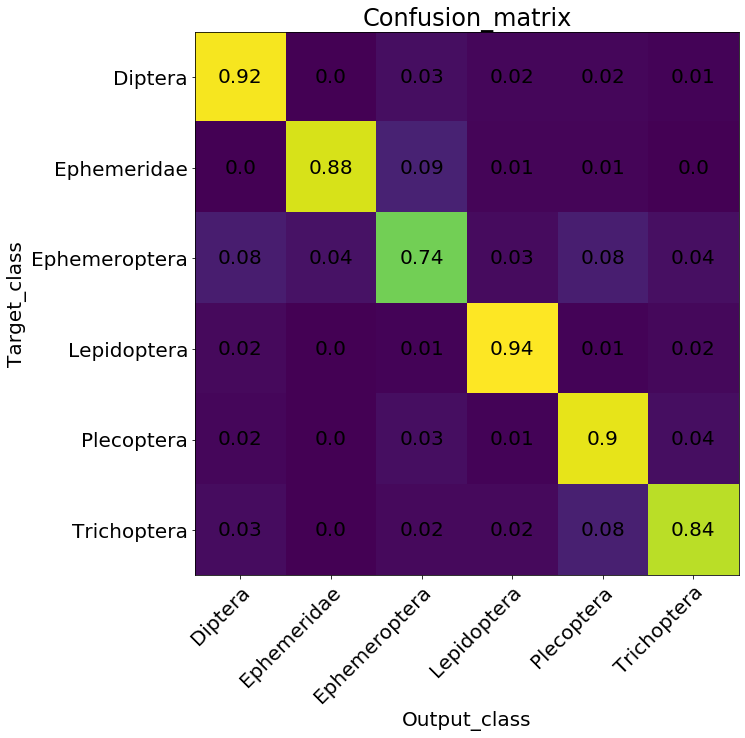

In [12]:
create_confusion_matrix(validation_matrix, ntests, args.labels, args.figure_root, save=args.save_fig)

In [13]:
each_df = compute_each_size_df(result, x_all, y_all)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,True,5632
1,True,13125
2,True,12190
3,True,4148
4,True,323
...,...,...
3050,False,30369
3051,True,8652
3052,False,6417
3053,True,21204


In [14]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,order,Accuracy,Insect_size
0,1.0,0.000000,2.000000
1,5.0,0.000000,42.000000
2,7.0,0.916667,205.833333
3,8.0,0.865385,395.903846
4,9.0,0.820312,772.078125
5,10.0,0.794224,1522.812274
6,11.0,0.872340,3023.295745
7,12.0,0.901961,5997.935049
8,13.0,0.908940,11531.438742
9,14.0,0.946502,23607.746914


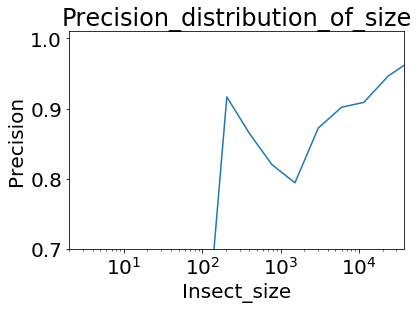

In [15]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)